# Unsupervised Learning applied to Customer Lifetime Value (CLV)

![](https://wilsonprintingusa.com/wp-content/uploads/2015/02/Customer-Lifetime-Value-Wilson-Printing.jpg)

# Prepare Workspace

In [1]:
# Upload libraries
from numpy.random import seed
seed(1)
import tensorflow.keras
tensorflow.random.set_seed(2)

# to handle datasets
import numpy as np
import pandas as pd
import datetime

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# for statistics
import statistics as st 
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# to split data set 
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# to build models
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# dimensionality reductiion
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from keras.layers import Input,Dense
from keras.models import Model

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# to evaluate models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AutoInsurance.csv')

# Data set Overview

In [3]:
# Dimensions of data set
print(df.shape)

(9134, 24)


In [4]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [5]:
# Take a peek at the first rows of the data
df.head()

Customer       State  Customer Lifetime Value Response  Coverage Education  \
0  BU79786  Washington              2763.519279       No     Basic  Bachelor   
1  QZ44356     Arizona              6979.535903       No  Extended  Bachelor   
2  AI49188      Nevada             12887.431650       No   Premium  Bachelor   
3  WW63253  California              7645.861827       No     Basic  Bachelor   
4  HB64268  Washington              2813.692575       No     Basic  Bachelor   

  Effective To Date EmploymentStatus Gender  Income  ...  \
0           2/24/11         Employed      F   56274  ...   
1           1/31/11       Unemployed      F       0  ...   
2           2/19/11         Employed      F   48767  ...   
3           1/20/11       Unemployed      M       0  ...   
4          3/2/2011         Employed      M   43836  ...   

  Months Since Policy Inception Number of Open Complaints  Number of Policies  \
0                             5                         0                   1   
1                            42                         0                   8   
2                            38                         0                   2   
3                            65                         0                   7   
4                            44                         0                   1   

      Policy Type        Policy  Renew Offer Type  Sales Channel  \
0  Corporate Auto  Corporate L3            Offer1          Agent   
1   Personal Auto   Personal L3            Offer3          Agent   
2   Personal Auto   Personal L3            Offer1          Agent   
3  Corporate Auto  Corporate L2            Offer1    Call Center   
4   Personal Auto   Personal L1            Offer1          Agent   

  Total Claim Amount  Vehicle Class Vehicle Size  
0         384.811147   Two-Door Car      Medsize  
1        1131.464935  Four-Door Car      Medsize  
2         566.472247   Two-Door Car      Medsize  
3         529.881344            SUV      Medsize  
4         138.130879  Four-Door Car      Medsize  

[5 rows x 24 columns]

# Data Cleaning & Handling Variables Activity

In [6]:
# Change format Date
df_1 = df.copy()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])

### Handling Missing Values

In [7]:
# Check missing values both to numeric features and categorical features 
missing = df_1.isnull().sum()/df_1.shape[0]*100
missing

Customer                         0.0
State                            0.0
Customer Lifetime Value          0.0
Response                         0.0
Coverage                         0.0
Education                        0.0
Effective To Date                0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy Type                      0.0
Policy                           0.0
Renew Offer Type                 0.0
Sales Channel                    0.0
Total Claim Amount               0.0
Vehicle Class                    0.0
Vehicle Size                     0.0
Effective_Date                   0.0
dtype: float64

In [8]:
# Min Value Effective to Date Policy
df_1['Effective_Date'].min()

Timestamp('2011-01-01 00:00:00')

In [9]:
# Max Value Effective to Date Policy
df_1['Effective_Date'].max()

Timestamp('2011-12-02 00:00:00')

In [10]:
# End of Year (eoy) of the current Effective to Date
df_1['eoy_Effective_Date'] = pd.to_datetime('2011-12-31')

In [11]:
# Days missing to the end of the current year from effective to date
df_1['eoy_missing_days'] = (df_1['eoy_Effective_Date'] - df_1['Effective_Date']).dt.days

In [12]:
# check duplicates
df_1_duplicates = df_1[df_1.duplicated(['Customer'])]

In [13]:
df_1_duplicates

Empty DataFrame
Columns: [Customer, State, Customer Lifetime Value, Response, Coverage, Education, Effective To Date, EmploymentStatus, Gender, Income, Location Code, Marital Status, Monthly Premium Auto, Months Since Last Claim, Months Since Policy Inception, Number of Open Complaints, Number of Policies, Policy Type, Policy, Renew Offer Type, Sales Channel, Total Claim Amount, Vehicle Class, Vehicle Size, Effective_Date, eoy_Effective_Date, eoy_missing_days]
Index: []

[0 rows x 27 columns]

In [14]:
df_1 = df_1.drop(['Customer','Effective To Date','eoy_Effective_Date'], axis=1)

In [15]:
# Rename some features for a practical use
df_new = df_1.copy()
df_new = df_new.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

# Summary Statistics

In [16]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df_new.columns if df_new[var].dtype=='object']
df_new[obj_cols].describe().T

count unique            top  freq
State             9134      5     California  3150
Response          9134      2             No  7826
Coverage          9134      3          Basic  5568
Education         9134      5       Bachelor  2748
EmploymentStatus  9134      5       Employed  5698
Gender            9134      2              F  4658
Location_Code     9134      3       Suburban  5779
Marital_Status    9134      3        Married  5298
Policy_Type       9134      3  Personal Auto  6788
Policy            9134      9    Personal L3  3426
Renew_Offer_Type  9134      4         Offer1  3752
Sales_Channel     9134      4          Agent  3477
Vehicle_Class     9134      6  Four-Door Car  4621
Vehicle_Size      9134      3        Medsize  6424

In [17]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df_new.columns if df_new[var].dtype!='object']
df_new[no_obj_cols].describe().T

count          mean           std  \
Customer_Lifetime_Value        9134.0   8004.940475   6870.967608   
Income                         9134.0  37657.380009  30379.904734   
Monthly_Premium_Auto           9134.0     93.219291     34.407967   
Months_Since_Last_Claim        9134.0     15.097000     10.073257   
Months_Since_Policy_Inception  9134.0     48.064594     27.905991   
Number_of_Open_Complaints      9134.0      0.384388      0.910384   
Number_of_Policies             9134.0      2.966170      2.390182   
Total_Claim_Amount             9134.0    434.088794    290.500092   
eoy_missing_days               9134.0    276.667068     93.820412   

                                       min          25%           50%  \
Customer_Lifetime_Value        1898.007675  3994.251794   5780.182197   
Income                            0.000000     0.000000  33889.500000   
Monthly_Premium_Auto             61.000000    68.000000     83.000000   
Months_Since_Last_Claim           0.000000     6.000000     14.000000   
Months_Since_Policy_Inception     0.000000    24.000000     48.000000   
Number_of_Open_Complaints         0.000000     0.000000      0.000000   
Number_of_Policies                1.000000     1.000000      2.000000   
Total_Claim_Amount                0.099007   272.258244    383.945434   
eoy_missing_days                 29.000000   244.000000    315.000000   

                                        75%           max  
Customer_Lifetime_Value         8962.167041  83325.381190  
Income                         62320.000000  99981.000000  
Monthly_Premium_Auto             109.000000    298.000000  
Months_Since_Last_Claim           23.000000     35.000000  
Months_Since_Policy_Inception     71.000000     99.000000  
Number_of_Open_Complaints          0.000000      5.000000  
Number_of_Policies                 4.000000      9.000000  
Total_Claim_Amount               547.514839   2893.239678  
eoy_missing_days                 340.000000    364.000000

In [18]:
# Split data set between target variable and features
X_full = df_new.copy()
y = X_full.Customer_Lifetime_Value
X_full.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)

# Target Variable Analysis

In [19]:
# Univariate analysis looking at Mean, Variance, Standard Deviation, Skewness and Kurtosis
print(y.name,
      '\nMean :', np.mean(y),
      '\nVariance :', np.var(y),
      '\nStandard Deviation :', st.stdev(y), 
      '\nSkewness :', stats.skew(y), 
      '\nKurtosis :', stats.kurtosis(y))

Customer_Lifetime_Value 
Mean : 8004.940474987081 
Variance : 47205027.252813585 
Standard Deviation : 6870.9676083569375 
Skewness : 3.0317822713278852 
Kurtosis : 13.815310695287444


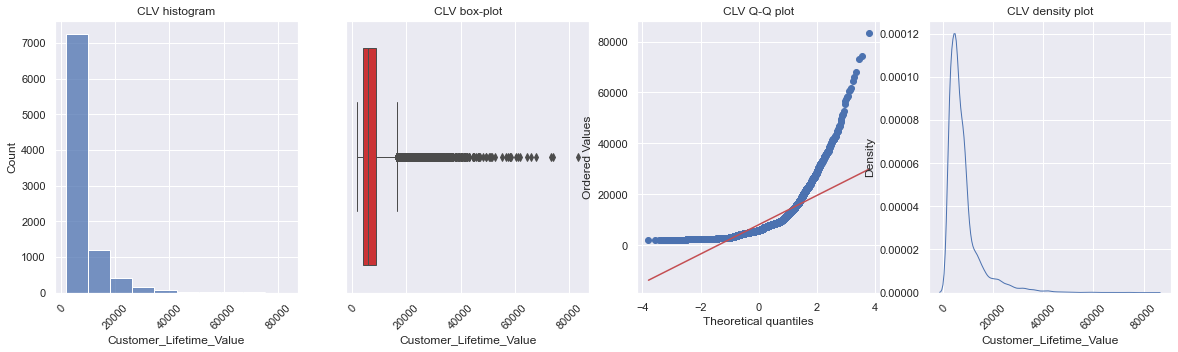

In [20]:
# Univariate analysis with density plots and histogram
sns.set( rc = {'figure.figsize': (20, 5)})
plt.subplot(1,4,1)  
sns.histplot(y, bins=10)
plt.xticks(rotation=45)
plt.title('CLV histogram')
# Univariate analysis with box-plots
plt.subplot(1,4,2)
sns.boxplot(y,palette="Set1",linewidth=1)
plt.xticks(rotation=45)
plt.title('CLV box-plot')
# Univariate analysis with QQ-plot
plt.subplot(1,4,3)  
res = stats.probplot(y, plot=plt)
plt.title('CLV Q-Q plot')
# Univariate analysis with density plot
plt.subplot(1,4,4)
sns.kdeplot(y,palette="Set1",linewidth=1)
plt.xticks(rotation=45)
plt.title('CLV density plot')
plt.show()

# Numerical Features Analysis

### Analysis for numerical features (univariate analysis, bivariate analysis)

In [21]:
# Select numerical columns
numerical_cols = [cname for cname in X_full.columns if 
                X_full[cname].dtype in ['float64','int64']]

In [22]:
# Subset with numerical features
num = X_full[numerical_cols]
num.columns

Index(['Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
       'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Total_Claim_Amount', 'eoy_missing_days'],
      dtype='object')

In [23]:
# list of numerical features
fnum = ['Income', 'Monthly_Premium_Auto', 'Months_Since_Last_Claim',
       'Months_Since_Policy_Inception', 'Number_of_Open_Complaints',
       'Number_of_Policies', 'Total_Claim_Amount', 'eoy_missing_days']

In [24]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
for col in fnum:
    print(col,
        '\nMean :', np.mean(num[col]),  
        '\nVariance :', np.var(num[col]),
        '\nStandard Deviation :', st.stdev(num[col]), 
        '\nSkewness :', stats.skew(num[col]), 
        '\nKurtosis :', stats.kurtosis(num[col]))

Income 
Mean : 37657.38000875848 
Variance : 922837567.3402659 
Standard Deviation : 30379.9047338463 
Skewness : 0.28684016057807576 
Kurtosis : -1.094383828097193
Monthly_Premium_Auto 
Mean : 93.21929056273265 
Variance : 1183.77860313147 
Standard Deviation : 34.40796737178653 
Skewness : 2.123197701864424 
Kurtosis : 6.189558258832852
Months_Since_Last_Claim 
Mean : 15.097000218962119 
Variance : 101.45938885548495 
Standard Deviation : 10.073256571394225 
Skewness : 0.2785405598366762 
Kurtosis : -1.0737368448075961
Months_Since_Policy_Inception 
Mean : 48.064593825268226 
Variance : 778.6590638978643 
Standard Deviation : 27.90599078426519 
Skewness : 0.040158365343045704 
Kurtosis : -1.1330825805856537
Number_of_Open_Complaints 
Mean : 0.38438800087584846 
Variance : 0.828707436930687 
Standard Deviation : 0.910383531613565 
Skewness : 2.7828059596647505 
Kurtosis : 7.744410297233042
Number_of_Policies 
Mean : 2.9661703525290126 
Variance : 5.712343621516475 
Standard Deviation 

<Figure size 360x360 with 0 Axes>

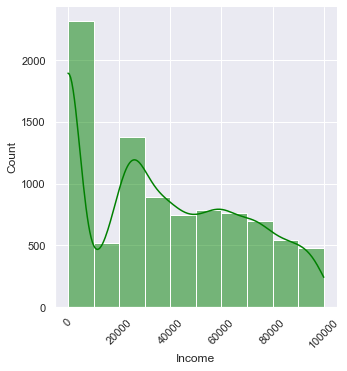

<Figure size 360x360 with 0 Axes>

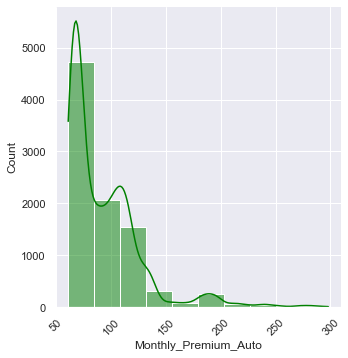

<Figure size 360x360 with 0 Axes>

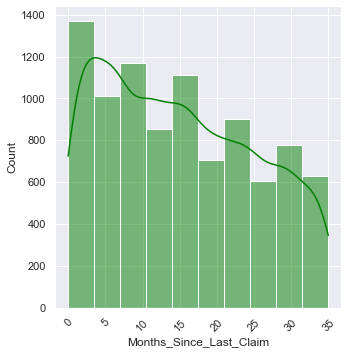

<Figure size 360x360 with 0 Axes>

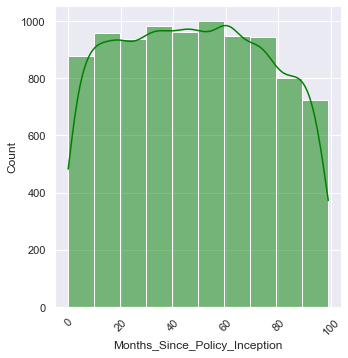

<Figure size 360x360 with 0 Axes>

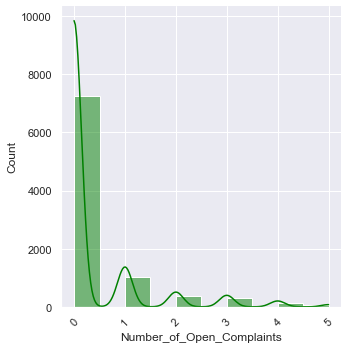

<Figure size 360x360 with 0 Axes>

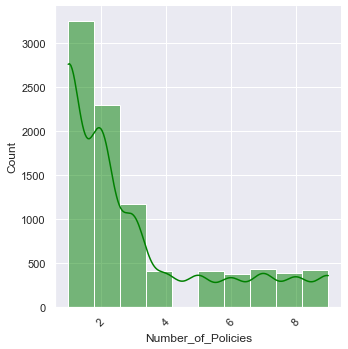

<Figure size 360x360 with 0 Axes>

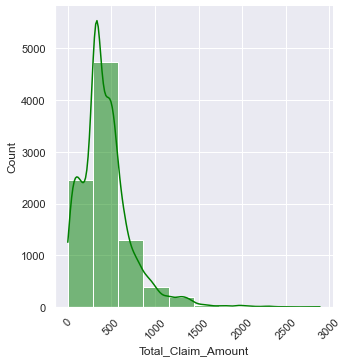

<Figure size 360x360 with 0 Axes>

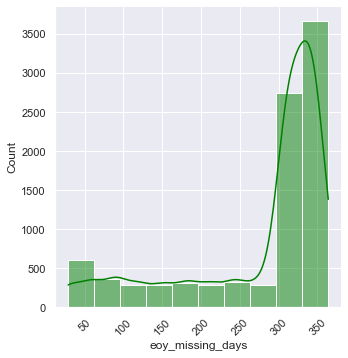

In [25]:
# Univariate analysis with density plots and histograms

for col in fnum:
    plt.figure(figsize=(5,5))
    sns.displot(x=num[col], bins=10, color='green', kde=True)
    plt.xticks(rotation=45)
    plt.show()

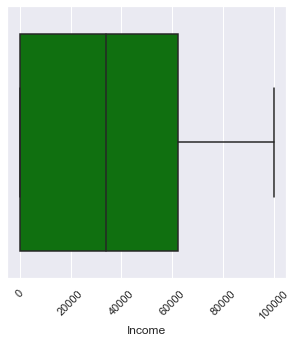

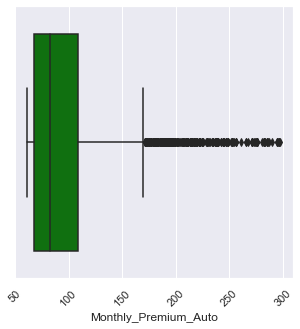

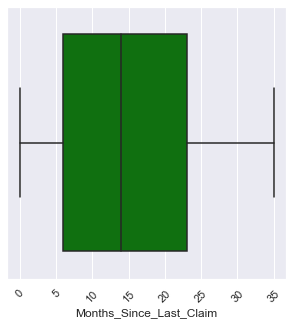

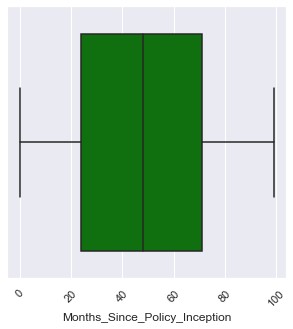

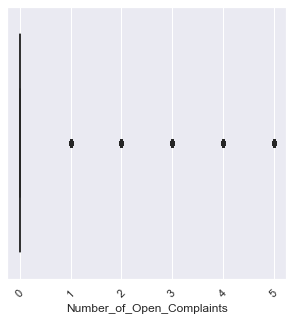

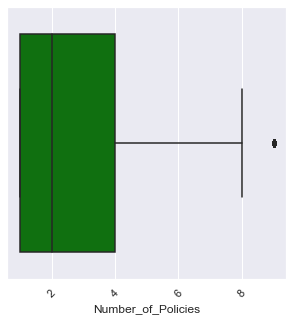

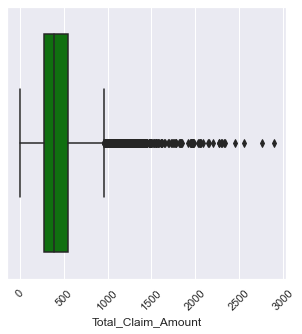

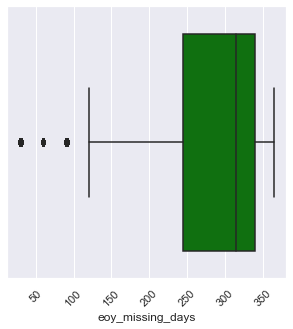

In [26]:
# Univariate analysis with box-plots
for col in fnum:
    plt.figure(figsize=(5,5))
    sns.boxplot(x=num[col], color="green")
    plt.xticks(rotation=45)
    plt.show()

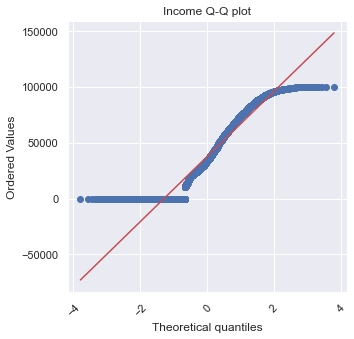

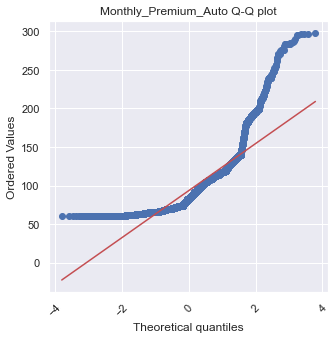

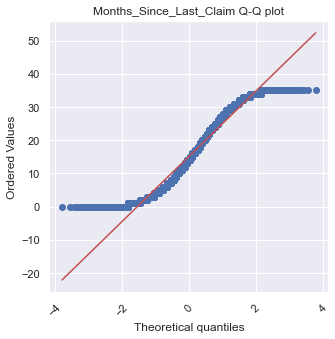

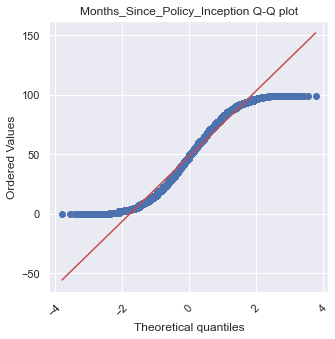

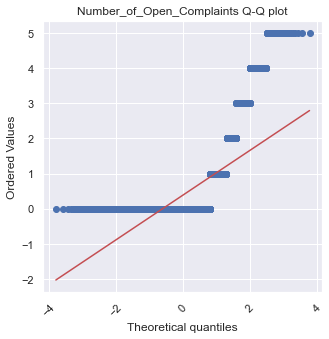

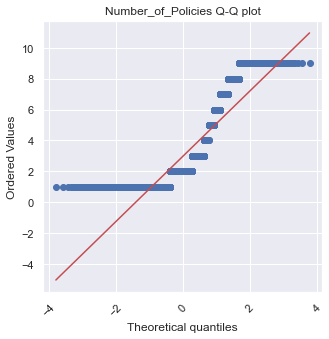

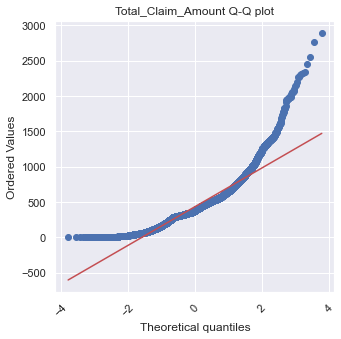

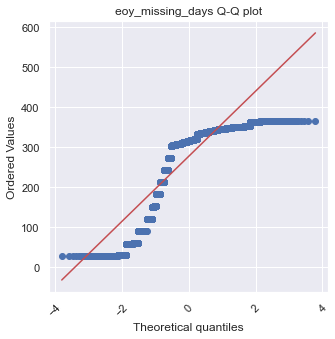

In [27]:
# Univariate analysis with Q-Q plot

for col in fnum:
    plt.figure(figsize=(5,5))
    res = stats.probplot(num[col], plot=plt)
    plt.title('{} Q-Q plot'.format(col))
    plt.xticks(rotation=45)
    plt.show()

In [28]:
# new subset for a bivariate analysis
num2 = pd.concat([y,num], axis=1)

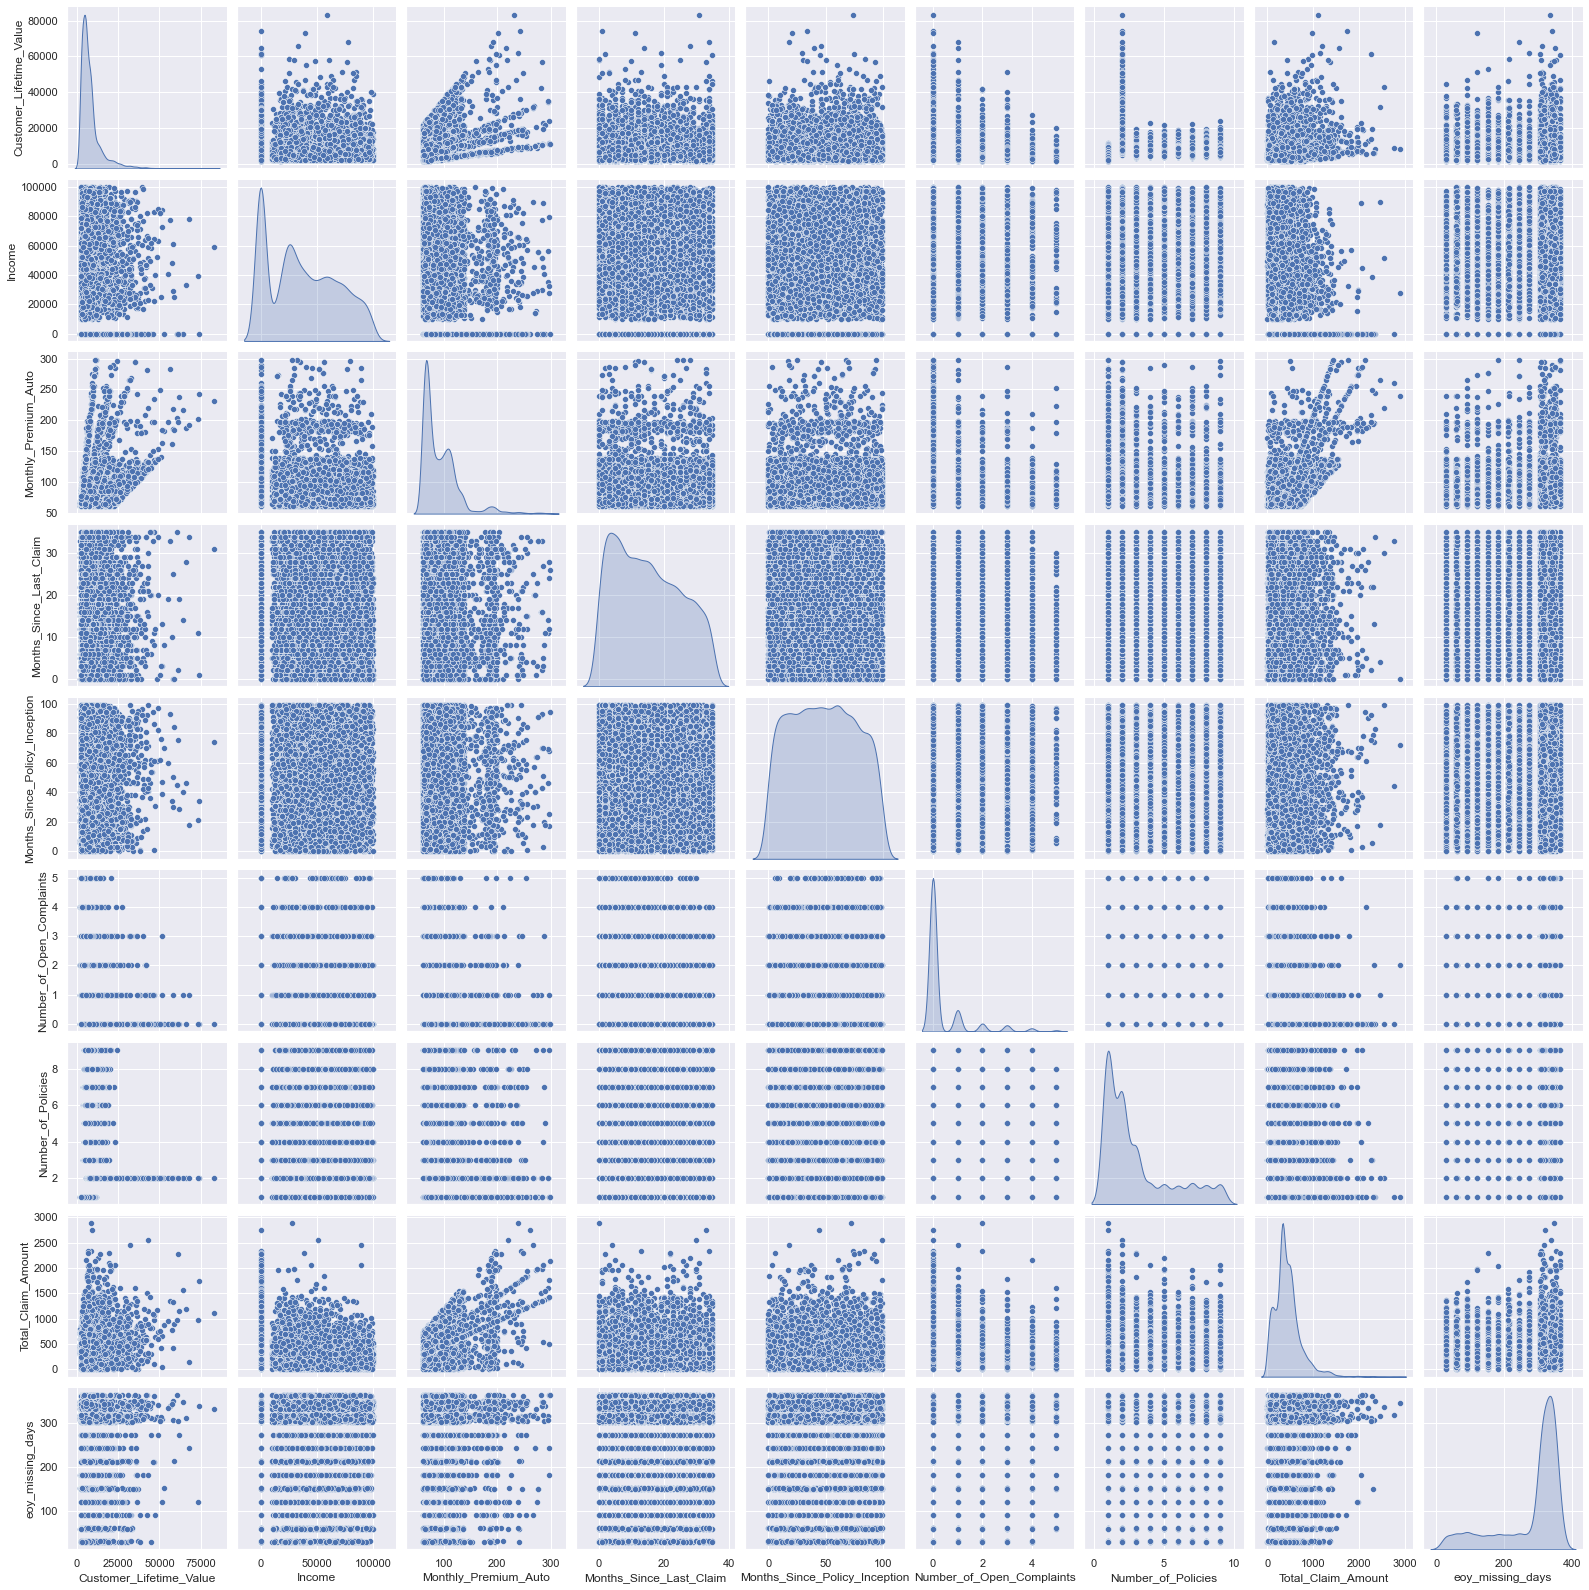

In [29]:
# Bivariate analysis with scatter-plot matrix
sns.pairplot(num2, kind ='scatter',diag_kind='kde')
plt.show()

### Dimensionality Reduction and Visualization with T-SNE

In [30]:
# Normalization of data
scaling = MinMaxScaler()
num_sc = scaling.fit_transform(num)

In [31]:
tsne = TSNE(n_components=2, random_state=0).fit_transform(num_sc)

In [32]:
tsne_df = pd.DataFrame(data = tsne, columns = ['x','y'], index=num.index)

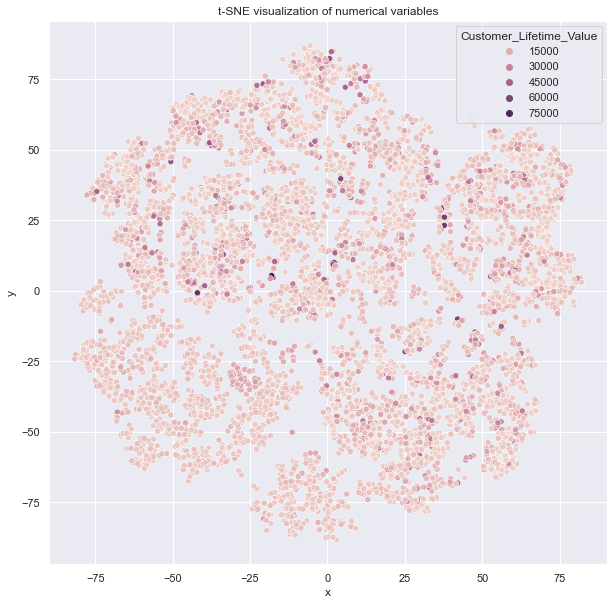

In [33]:
dff = pd.concat([df_new['Customer_Lifetime_Value'], tsne_df], axis=1)
# Show the diagram
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='x',y='y',hue='Customer_Lifetime_Value',data=dff)
plt.title('t-SNE visualization of numerical variables')
plt.show()

# Categorical Features Analysis

### Analysis for categorical features (univariate analysis, bivariate analysis)

In [34]:
# let's have a look at how many labels for categorical features
for col in X_full.columns:
    if X_full[col].dtype =="object":
        print(col, ': ', len(X_full[col].unique()), ' labels')

State :  5  labels
Response :  2  labels
Coverage :  3  labels
Education :  5  labels
EmploymentStatus :  5  labels
Gender :  2  labels
Location_Code :  3  labels
Marital_Status :  3  labels
Policy_Type :  3  labels
Policy :  9  labels
Renew_Offer_Type :  4  labels
Sales_Channel :  4  labels
Vehicle_Class :  6  labels
Vehicle_Size :  3  labels


In [35]:
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_full.columns if
                    X_full[cname].nunique() <= 15 and 
                    X_full[cname].dtype == "object"]

In [36]:
# Subset with categorical features
cat = X_full[categorical_cols]
cat.columns


Index(['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
       'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy',
       'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size'],
      dtype='object')

In [37]:
# List of categorical features
fcat = ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus',
       'Gender', 'Location_Code', 'Marital_Status', 'Policy_Type', 'Policy',
       'Renew_Offer_Type', 'Sales_Channel', 'Vehicle_Class', 'Vehicle_Size']

In [38]:
# Univariate analysis looking at frequency
for col in fcat:
    count = pd.crosstab(index = cat[col], columns="count")
    percentage = pd.crosstab(index = cat[col], columns="frequency")/pd.crosstab(index = cat[col], columns="frequency").sum()
    tab = pd.concat([count, percentage], axis=1)
    print('\n',tab)


 col_0       count  frequency
State                       
Arizona      1703   0.186446
California   3150   0.344865
Nevada        882   0.096562
Oregon       2601   0.284760
Washington    798   0.087366

 col_0     count  frequency
Response                  
No         7826   0.856799
Yes        1308   0.143201

 col_0     count  frequency
Coverage                  
Basic      5568   0.609591
Extended   2742   0.300197
Premium     824   0.090212

 col_0                 count  frequency
Education                             
Bachelor               2748   0.300854
College                2681   0.293519
Doctor                  342   0.037443
High School or Below   2622   0.287059
Master                  741   0.081125

 col_0             count  frequency
EmploymentStatus                  
Disabled            405   0.044340
Employed           5698   0.623823
Medical Leave       432   0.047296
Retired             282   0.030874
Unemployed         2317   0.253668

 col_0   count  frequency

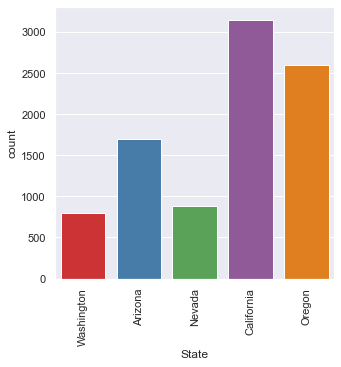

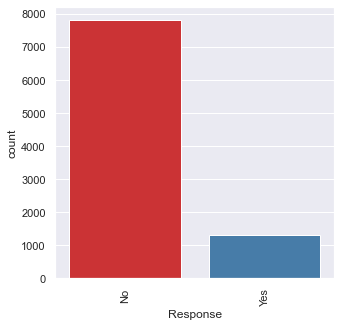

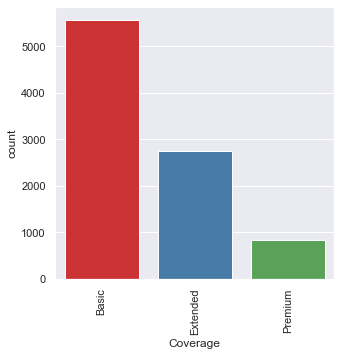

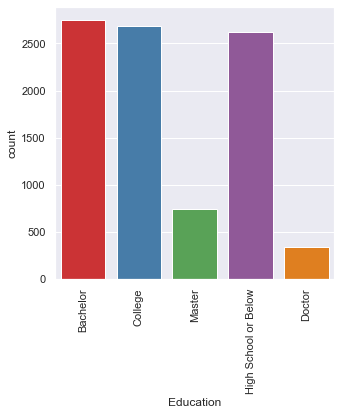

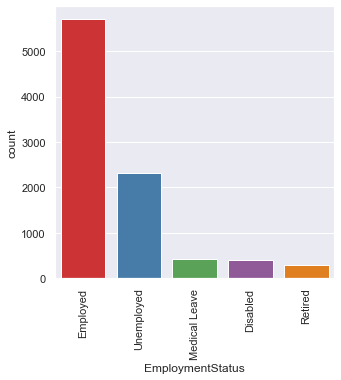

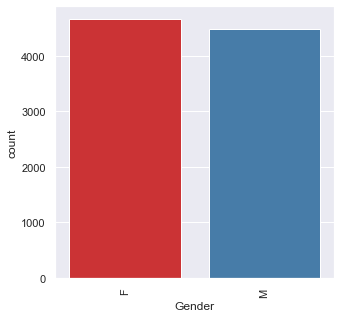

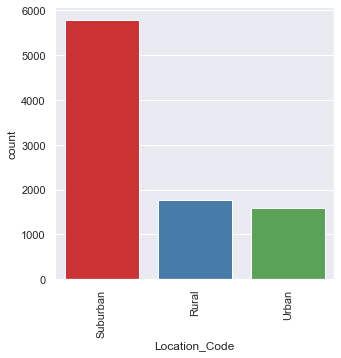

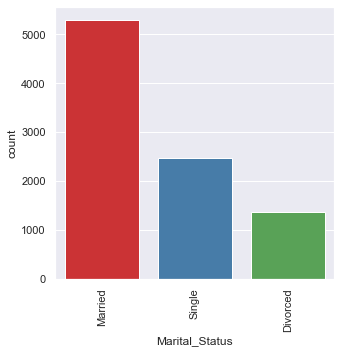

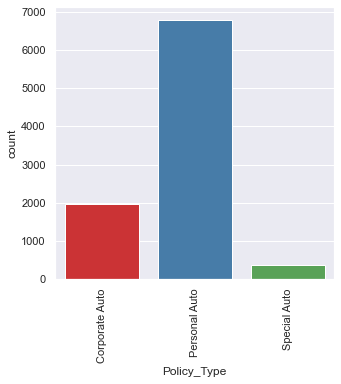

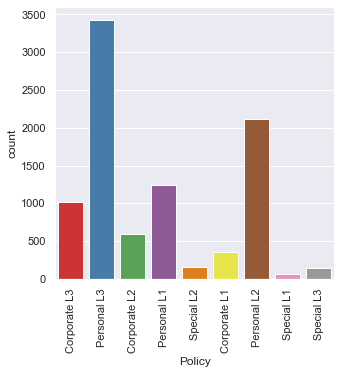

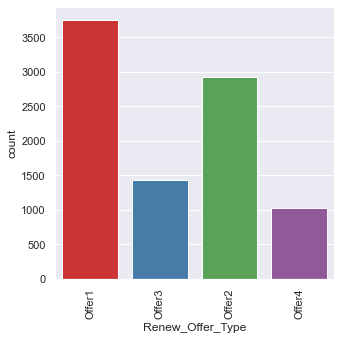

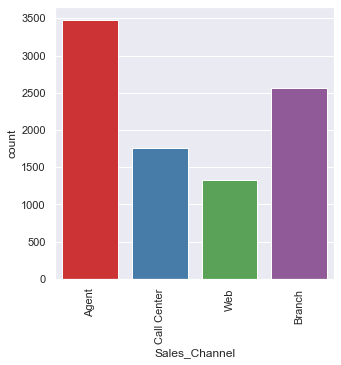

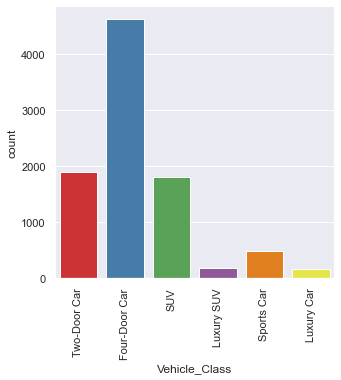

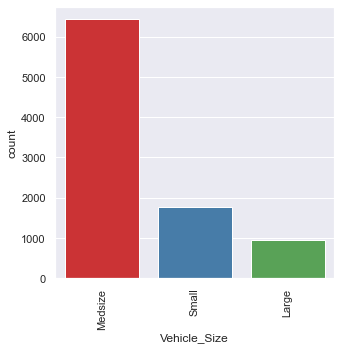

In [39]:
# Univariate analysis with barplots

for col in fcat:
    plt.figure(figsize=(5,5))
    sns.countplot(x=cat[col], data=cat, palette="Set1")
    plt.xticks(rotation=90)
    plt.show()

In [40]:
# new subset for a bivariate analysis
cat2 = pd.concat([y,cat], axis=1)

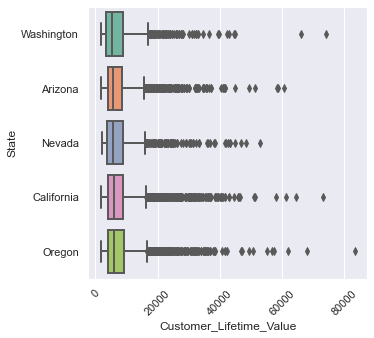

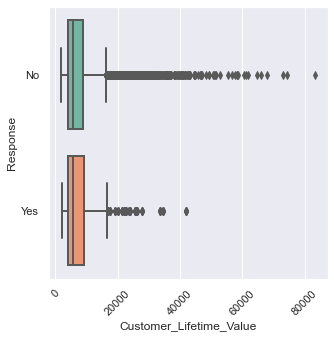

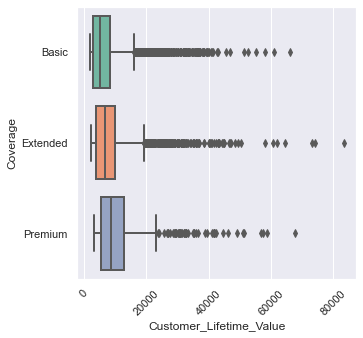

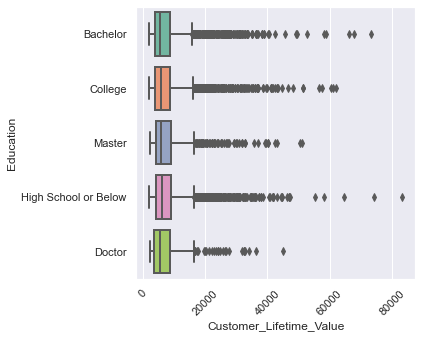

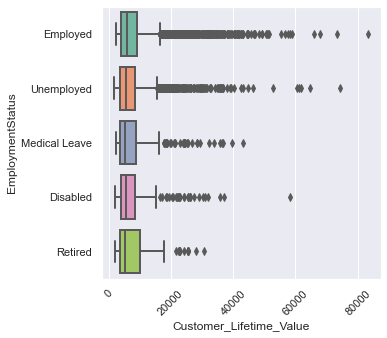

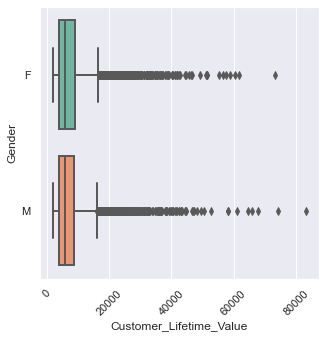

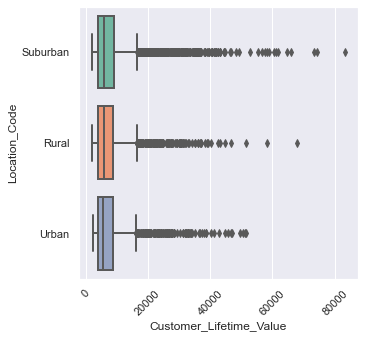

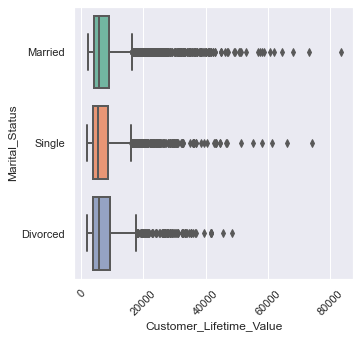

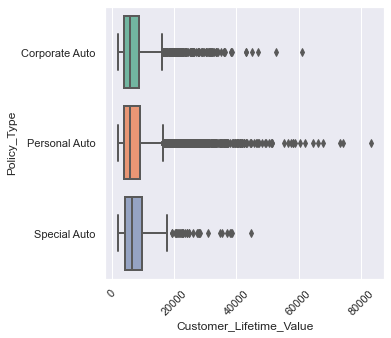

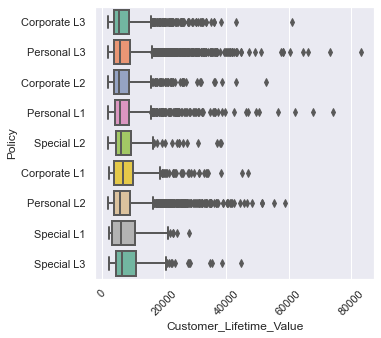

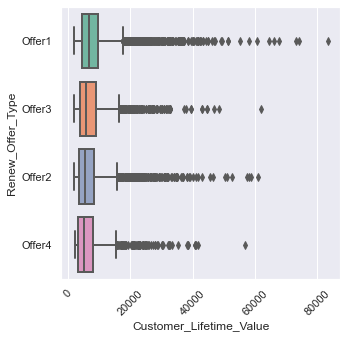

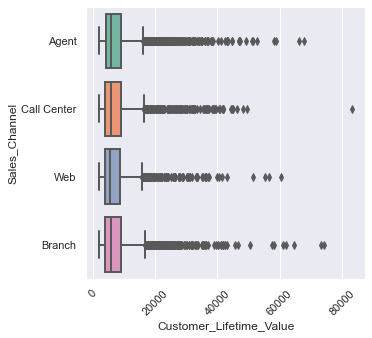

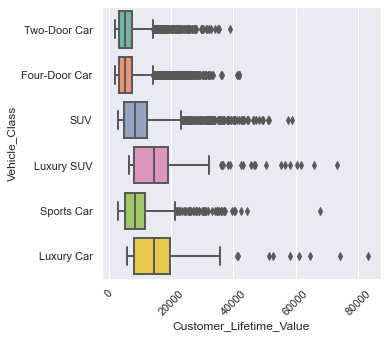

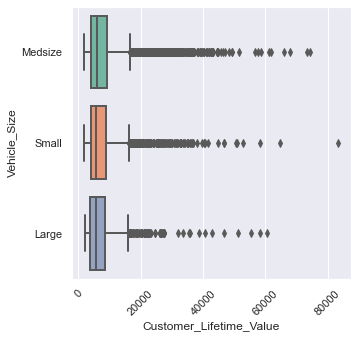

In [41]:
# Bivariate analysis with box-plots
for col in fcat:
    plt.figure(figsize=(5,5))
    sns.boxplot(y=cat2[col], x=cat2['Customer_Lifetime_Value'], linewidth=2, palette="Set2")
    plt.xticks(rotation=45)
    plt.show()

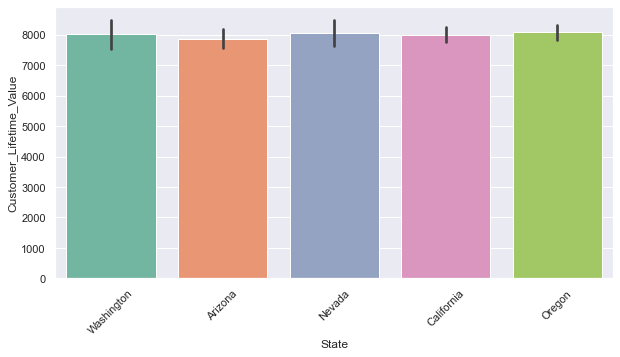

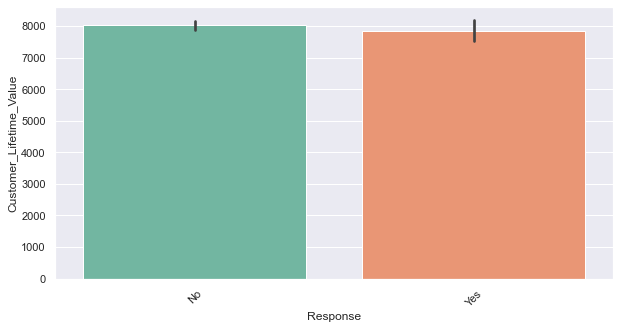

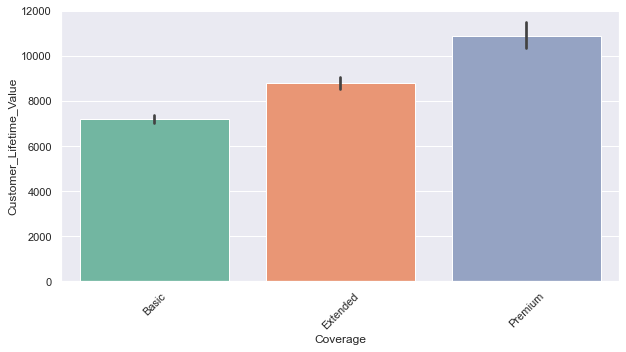

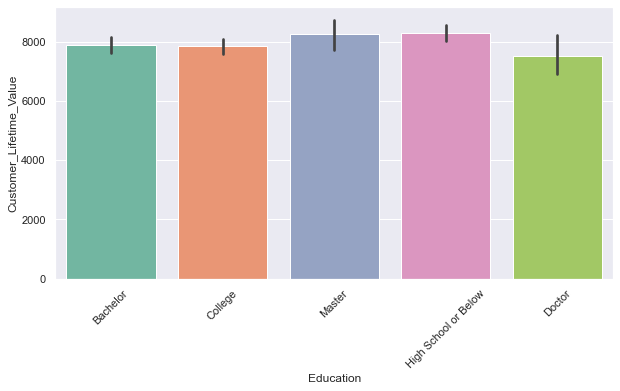

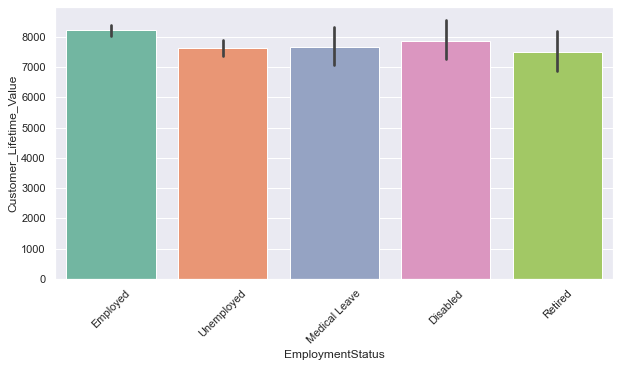

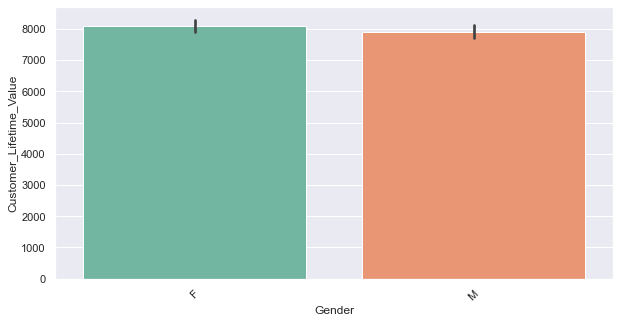

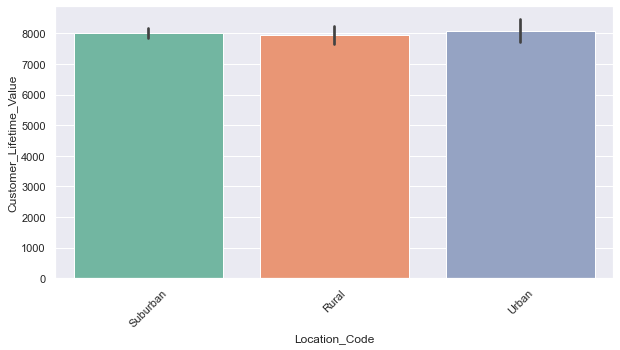

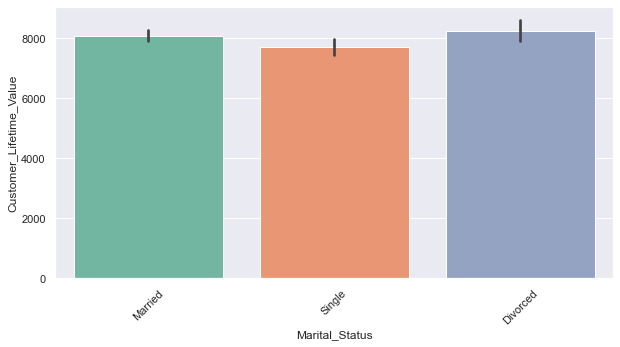

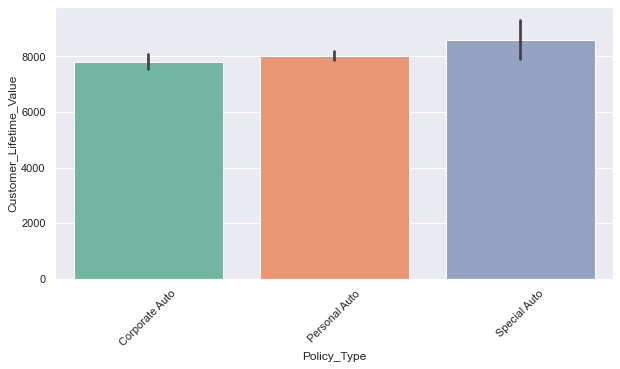

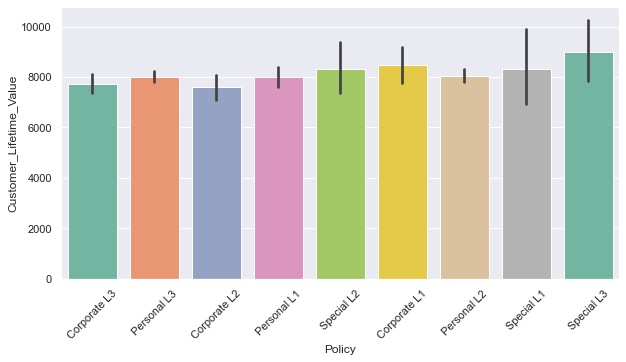

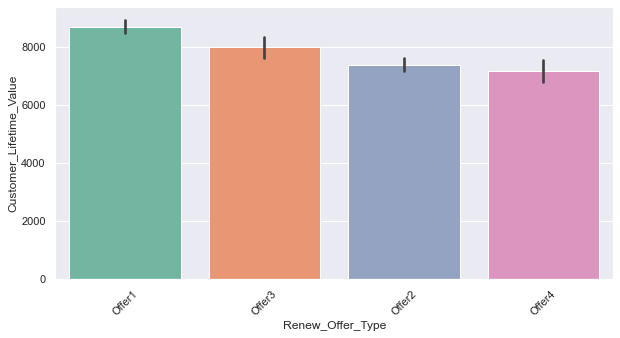

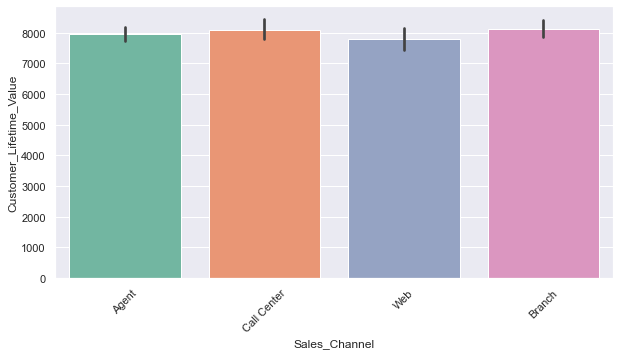

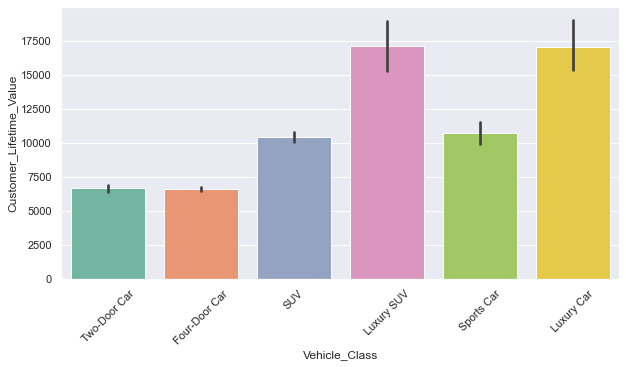

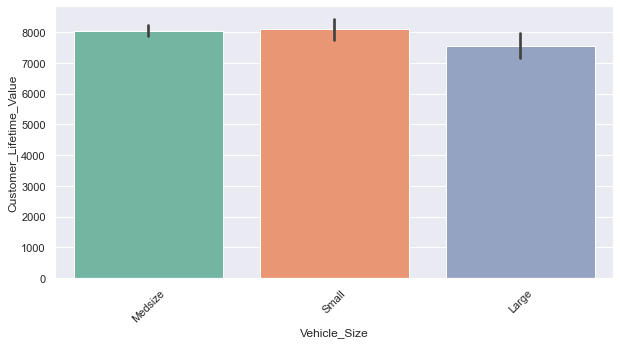

In [42]:
# Bivariate analysis with barplots
for col in fcat:
    plt.figure(figsize=(10,5))
    sns.barplot(y=cat2['Customer_Lifetime_Value'], x=cat2[col], palette="Set2")
    plt.xticks(rotation=45)
    plt.show()

In [43]:
# Function for query and barplot about Customer_Lifetime_Value per each class of variable
def query(data,col):
    # groupby
    df = data.groupby(data[col], as_index=False)['Customer_Lifetime_Value'].sum()
    df['PERCENTAGE'] = df['Customer_Lifetime_Value']/df['Customer_Lifetime_Value'].sum()*100
    # dropping not matching rows
    df = df.dropna()
    # ranking 
    df = df.sort_values(by = 'Customer_Lifetime_Value', ascending = False).reset_index(drop=True)
    df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Customer_Lifetime_Value':"{:,.2f}"})
    # barplot
    index=list(df.columns[0:1])
    barplot = df[df.columns[0:2]].sort_values(by = "Customer_Lifetime_Value", ascending = True).set_index(index).plot.barh()
    plt.xticks(rotation=0)
    plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
    return df_q
    plt.show()
    return barplot
    plt.show()

Customer_Lifetime_Value per State


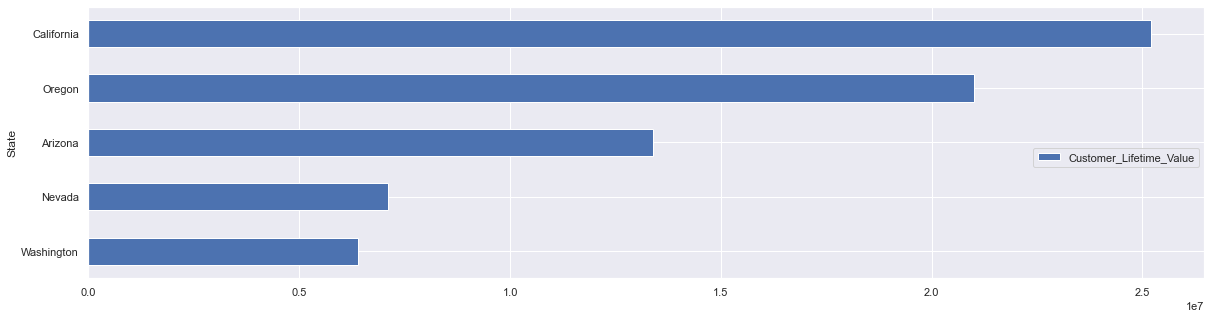

In [44]:
# query and barplot
variable = 'State'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='State')

Customer_Lifetime_Value per Response


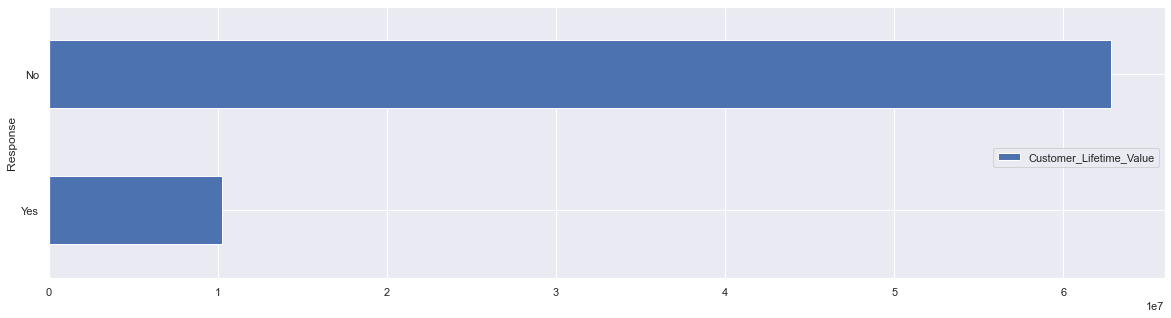

In [45]:
# query and barplot
variable = 'Response'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Response')

Customer_Lifetime_Value per Coverage


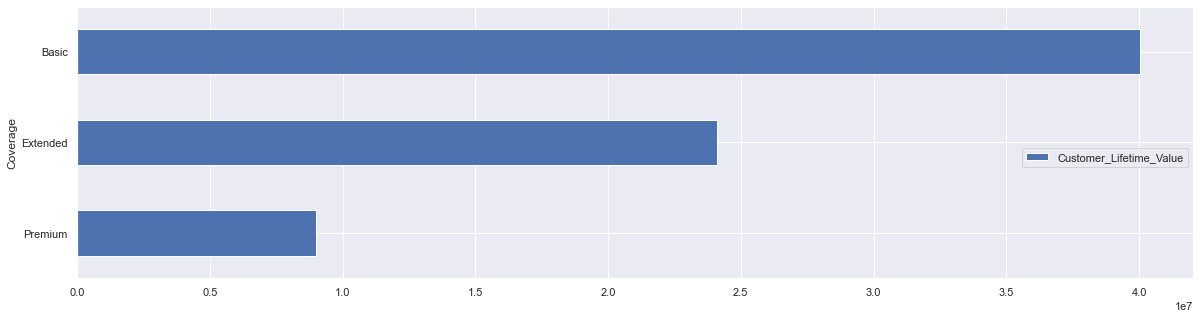

In [46]:
# query and barplot
variable = 'Coverage'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Coverage')

Customer_Lifetime_Value per Education


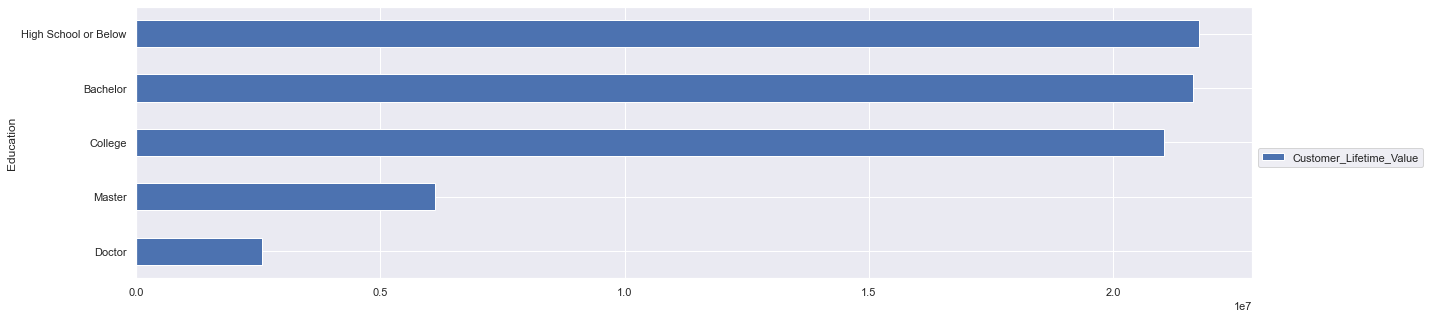

In [47]:
# query and barplot
variable = 'Education'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Education')

Customer_Lifetime_Value per EmploymentStatus


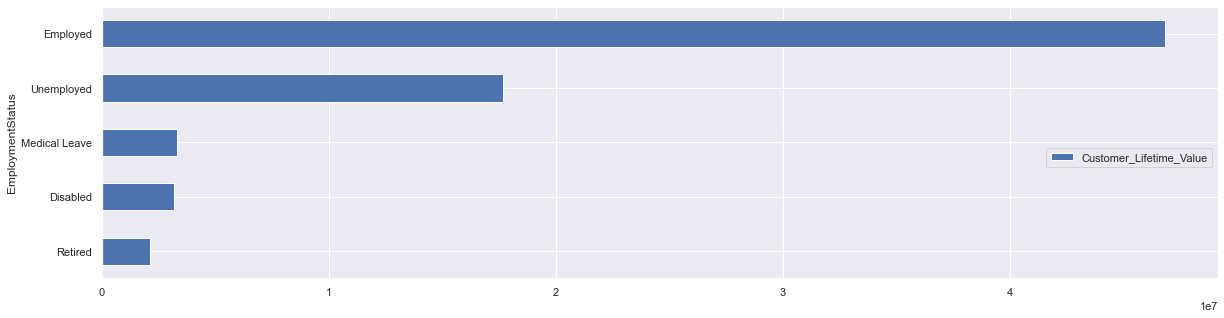

In [48]:
# query and barplot
variable = 'EmploymentStatus'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='EmploymentStatus')

Customer_Lifetime_Value per Gender


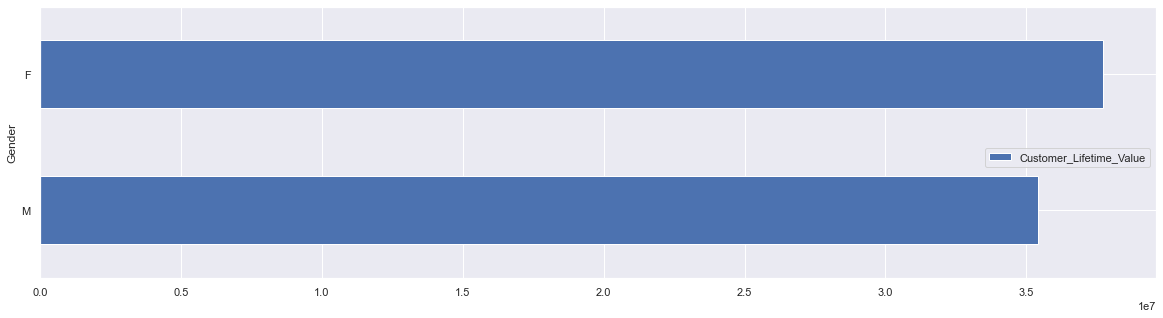

In [49]:
# query and barplot
variable = 'Gender'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Gender')

Customer_Lifetime_Value per Location_Code


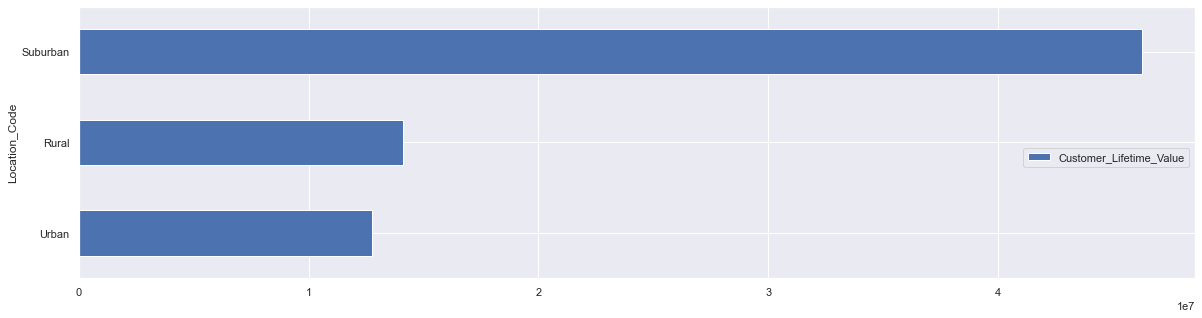

In [50]:
# query and barplot
variable = 'Location_Code'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Location_Code')

Customer_Lifetime_Value per Marital_Status


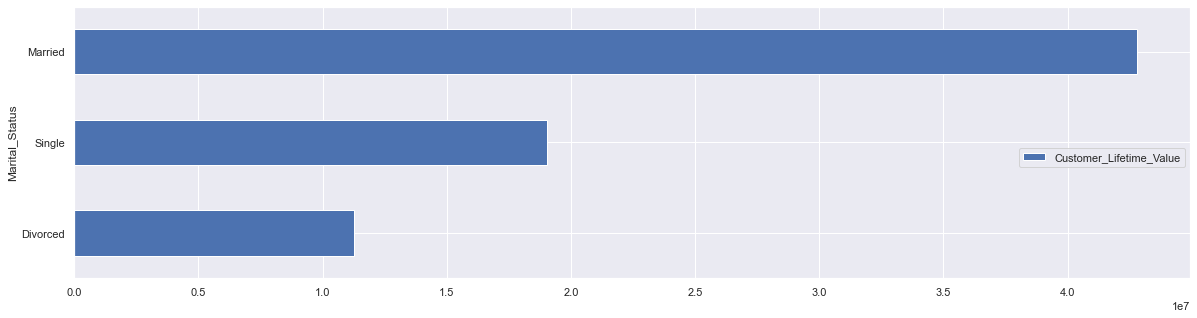

In [51]:
# query and barplot
variable = 'Marital_Status'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Marital_Status')

Customer_Lifetime_Value per Policy_Type


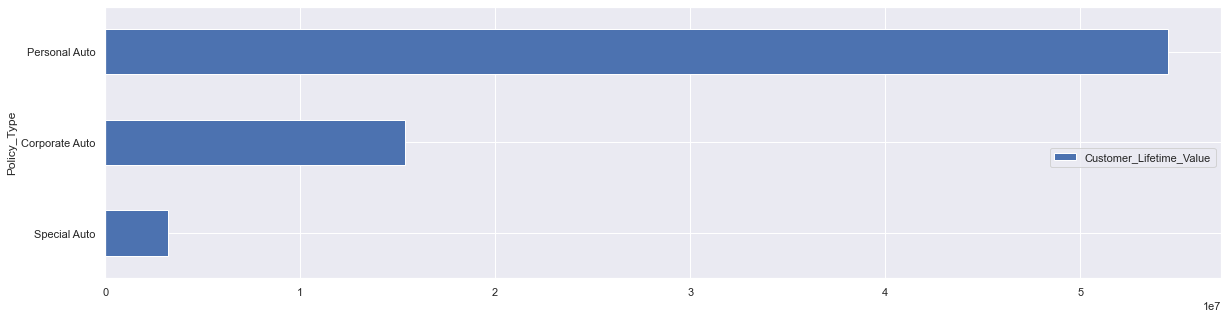

In [52]:
# query and barplot
variable = 'Policy_Type'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Policy_Type')

Customer_Lifetime_Value per Policy


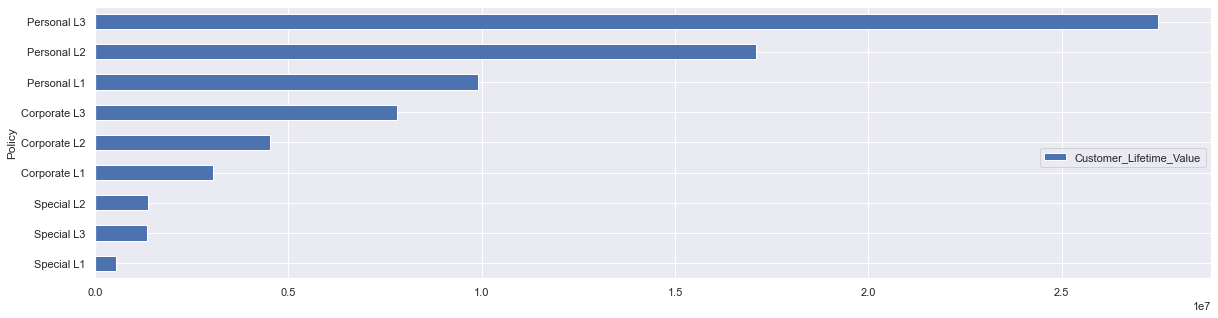

In [53]:
# query and barplot
variable = 'Policy'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Policy')

Customer_Lifetime_Value per Renew_Offer_Type


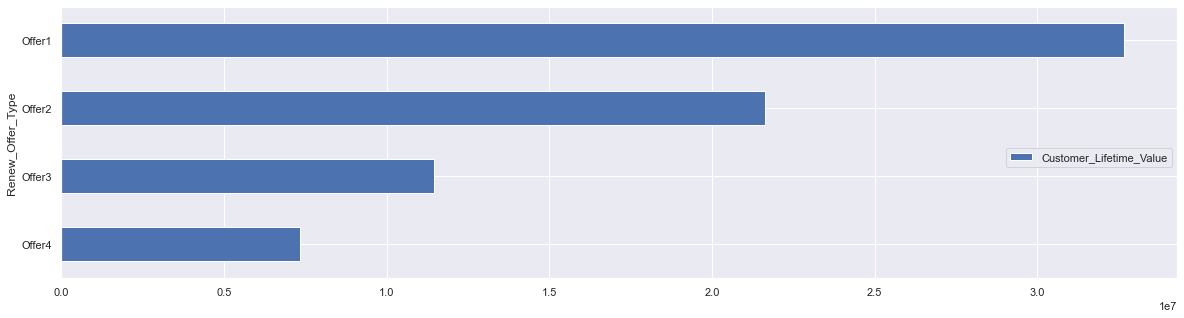

In [54]:
# query and barplot
variable = 'Renew_Offer_Type'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Renew_Offer_Type')

Customer_Lifetime_Value per Sales_Channel


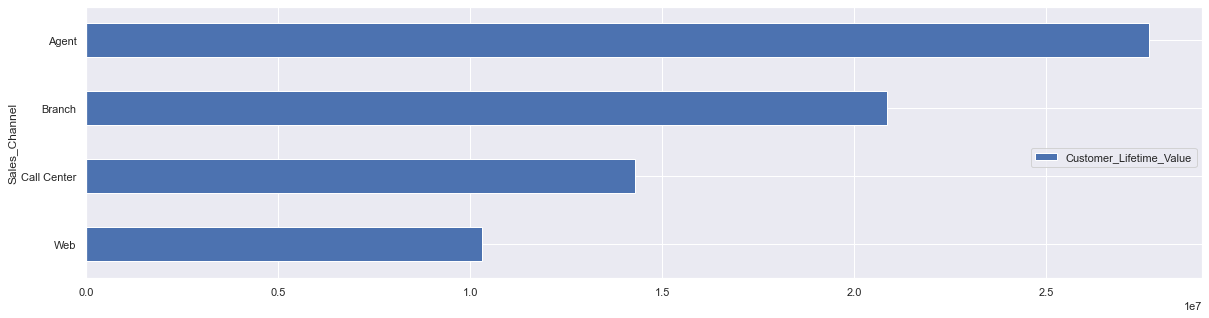

In [55]:
# query and barplot
variable = 'Sales_Channel'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Sales_Channel')

Customer_Lifetime_Value per Vehicle_Class


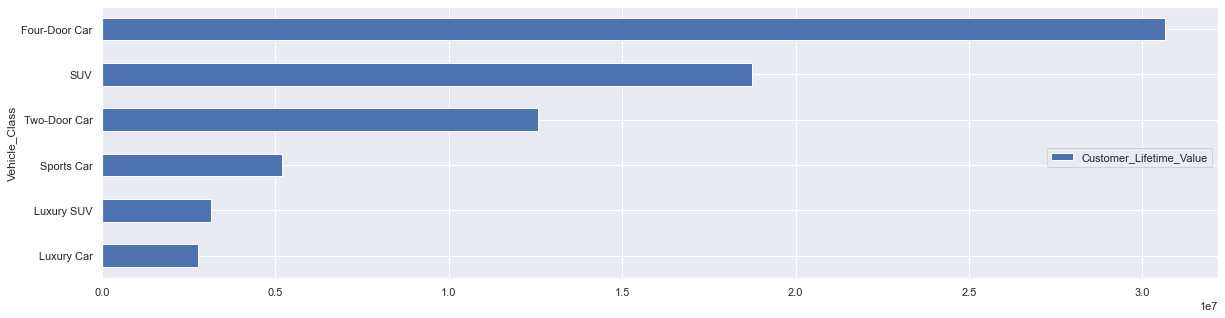

In [56]:
# query and barplot
variable = 'Vehicle_Class'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Vehicle_Class')

Customer_Lifetime_Value per Vehicle_Size


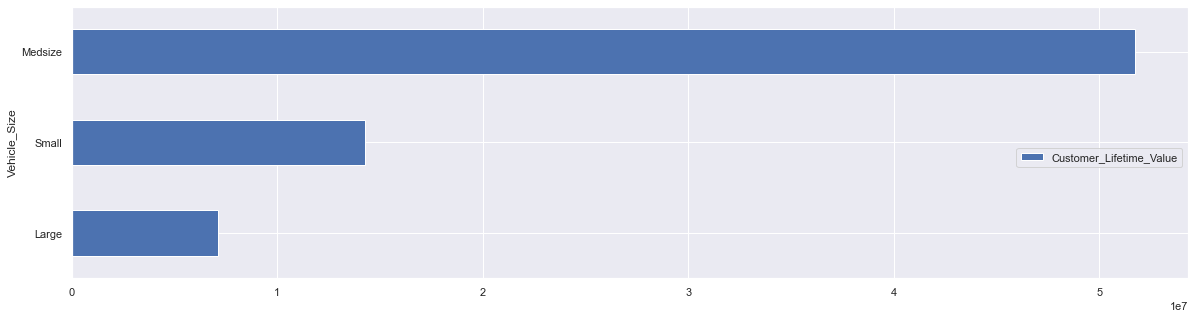

In [57]:
# query and barplot
variable = 'Vehicle_Size'
print('Customer_Lifetime_Value per {}'.format(variable))
query(cat2, col='Vehicle_Size')

# Clustering numerical features with K-Means

In [58]:
# Standardization of data
sc = StandardScaler()
num_sc = sc.fit_transform(num)

In [59]:
np.random.seed(0)
for n_cluster in range(2,10):
    clustering = KMeans(n_clusters=n_cluster, random_state=0).fit(num_sc)
    preds = clustering.predict(num_sc)
    silhouette_avg = silhouette_score(num_sc, preds)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 2 Clusters: 0.1637
Silhouette Score for 3 Clusters: 0.1607
Silhouette Score for 4 Clusters: 0.1758
Silhouette Score for 5 Clusters: 0.1525
Silhouette Score for 6 Clusters: 0.1603
Silhouette Score for 7 Clusters: 0.1504
Silhouette Score for 8 Clusters: 0.1462
Silhouette Score for 9 Clusters: 0.1429


In [60]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(num_sc)

In [61]:
cluster_num = num.copy()
cluster_num['kmeans_cluster'] = kmeans.labels_

In [62]:
kmeans.labels_

array([0, 3, 0, ..., 1, 0, 0])

In [63]:
cluster_num['kmeans_cluster'].value_counts()

0    5442
3    1672
2    1242
1     778
Name: kmeans_cluster, dtype: int64

In [64]:
tsne_num = TSNE(n_components=2, random_state=0).fit_transform(num_sc)

In [65]:
tsne_num_df = pd.DataFrame(data = tsne_num, columns = ['x','y'], index=num.index)

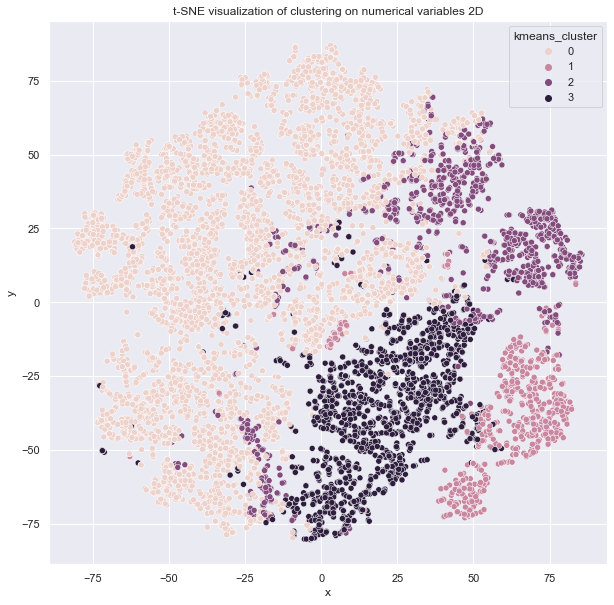

In [66]:
dff_km = pd.concat([cluster_num['kmeans_cluster'], tsne_num_df], axis=1)
# Show the diagram
fig = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='x',y='y',hue='kmeans_cluster',data=dff_km)
plt.title('t-SNE visualization of clustering on numerical variables 2D')
plt.show()

In [67]:
cluster_num_sc = sc.fit_transform(cluster_num)

In [68]:
tsne_3d = TSNE(n_components=3, random_state=0).fit_transform(cluster_num_sc)

In [69]:
tsne_df_3d = pd.DataFrame(data = tsne_3d, columns = ['x','y','z'], index=num.index)

In [70]:
dff = pd.concat([cluster_num['kmeans_cluster'], tsne_df_3d], axis=1)

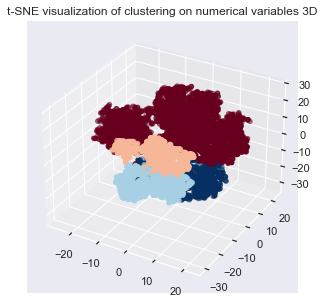

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = dff['x']
y = dff['y']
z = dff['z']
d= dff['kmeans_cluster']
ax.scatter(x,y,z,c=d, cmap='RdBu')
plt.title('t-SNE visualization of clustering on numerical variables 3D')
plt.show()

In [72]:
df = cluster_num.groupby(cluster_num['kmeans_cluster'], as_index=False)['Monthly_Premium_Auto'].sum()
df['PERCENTAGE'] = df['Monthly_Premium_Auto']/df['Monthly_Premium_Auto'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Monthly_Premium_Auto', ascending = False).reset_index(drop=True)
df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Monthly_Premium_Auto':"{:,.2f}"})
df_q

In [73]:
df = cluster_num.groupby(cluster_num['kmeans_cluster'], as_index=False)['Number_of_Open_Complaints'].sum()
df['PERCENTAGE'] = df['Number_of_Open_Complaints']/df['Number_of_Open_Complaints'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Number_of_Open_Complaints', ascending = False).reset_index(drop=True)
df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Number_of_Open_Complaints':"{:,.2f}"})
df_q

In [74]:
df = cluster_num.groupby(cluster_num['kmeans_cluster'], as_index=False)['Total_Claim_Amount'].sum()
df['PERCENTAGE'] = df['Total_Claim_Amount']/df['Total_Claim_Amount'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Total_Claim_Amount', ascending = False).reset_index(drop=True)
df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Total_Claim_Amount':"{:,.2f}"})
df_q

In [75]:
df = cluster_num.groupby(cluster_num['kmeans_cluster'], as_index=False)['Number_of_Policies'].sum()
df['PERCENTAGE'] = df['Number_of_Policies']/df['Number_of_Policies'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Number_of_Policies', ascending = False).reset_index(drop=True)
df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Number_of_Policies':"{:,.2f}"})
df_q

In [76]:
df = cluster_num.groupby(cluster_num['kmeans_cluster'], as_index=False)['Months_Since_Last_Claim'].mean()
df['PERCENTAGE'] = df['Months_Since_Last_Claim']/df['Months_Since_Last_Claim'].sum()*100
# dropping not matching rows
df = df.dropna()
# ranking 
df = df.sort_values(by = 'Months_Since_Last_Claim', ascending = False).reset_index(drop=True)
df_q = df.style.background_gradient(cmap='winter').format({'PERCENTAGE': "{:.2f}"}).format({'Months_Since_Last_Claim':"{:,.2f}"})
df_q

# Pre-Processing on all data set

### One-Hot Encoding into k-1 dummy variables

In [77]:
# Encode the categorical data 
dummy_cat = pd.concat([pd.get_dummies(cat.State, prefix='State',drop_first=True), 
                       pd.get_dummies(cat.Coverage, prefix= 'Coverage', drop_first=True), 
                       pd.get_dummies(cat.Response, prefix= 'Response', drop_first=True),
                       pd.get_dummies(cat.Education, prefix='Education',drop_first=True),
                       pd.get_dummies(cat.EmploymentStatus, prefix='EmploymentStatus',drop_first=True),
                       pd.get_dummies(cat.Gender, prefix='Gender',drop_first=True),
                       pd.get_dummies(cat.Location_Code, prefix='Location_Code',drop_first=True),
                       pd.get_dummies(cat.Marital_Status, prefix='Marital_Status',drop_first=True),
                       pd.get_dummies(cat.Policy_Type, prefix='Policy_Type',drop_first=True),
                       pd.get_dummies(cat.Policy, prefix='Policy',drop_first=True),
                       pd.get_dummies(cat.Renew_Offer_Type, prefix='Renew_Offer_Type',drop_first=True),
                       pd.get_dummies(cat.Sales_Channel, prefix='Sales_Channel',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Size, prefix='Vehicle_Size',drop_first=True),
                       pd.get_dummies(cat.Vehicle_Class, prefix='Vehicle_Class',drop_first=True)], axis=1)
dummy_cat = dummy_cat.astype(int)

In [78]:
cluster_num_ = pd.concat([num, pd.get_dummies(cluster_num.kmeans_cluster, prefix='cluster',drop_first=True)],axis=1)

In [79]:
# Grasp all
X_all = pd.concat([dummy_cat, cluster_num_], axis=1)

### Zero/Close Zero Variance Predictors

In [80]:
# Find features with variance equal zero or lower than 0.05
to_drop = [col for col in X_all.columns if np.var(X_all[col]) < 0.05]
to_drop

['Education_Doctor',
 'EmploymentStatus_Medical Leave',
 'EmploymentStatus_Retired',
 'Policy_Type_Special Auto',
 'Policy_Special L1',
 'Policy_Special L2',
 'Policy_Special L3',
 'Vehicle_Class_Luxury Car',
 'Vehicle_Class_Luxury SUV']

In [81]:
# Drop features 
X_all = X_all.drop(X_all[to_drop], axis=1)

In [82]:
# Look at the new data set
X_all.shape

(9134, 45)

### Correlated Predictors

In [83]:
# Correlation heatmap
corr_matrix = X_all.corr()

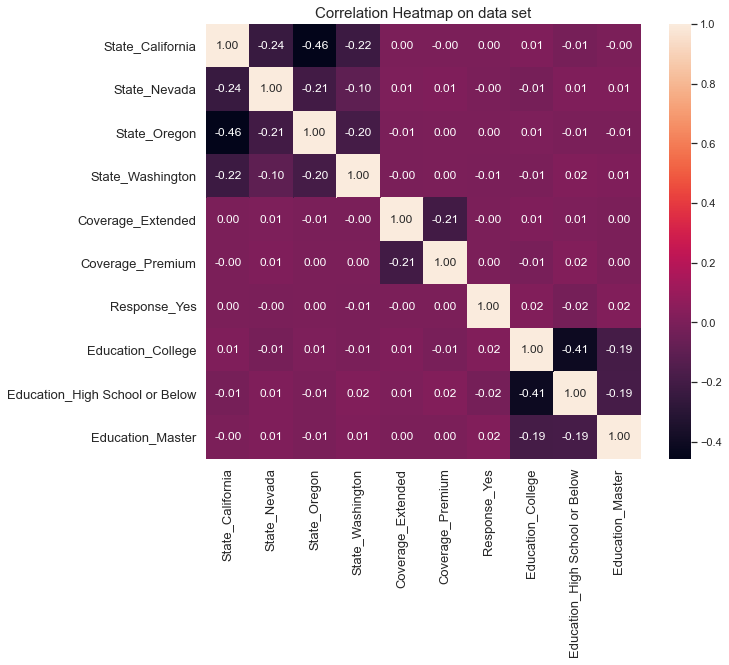

In [84]:
sns.set( rc = {'figure.figsize': (10, 8)})
plt.figure()
sns.heatmap(corr_matrix.iloc[0:10,0:10], square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=15)
plt.yticks(fontsize="13")
plt.xticks(fontsize="13")
plt.show()

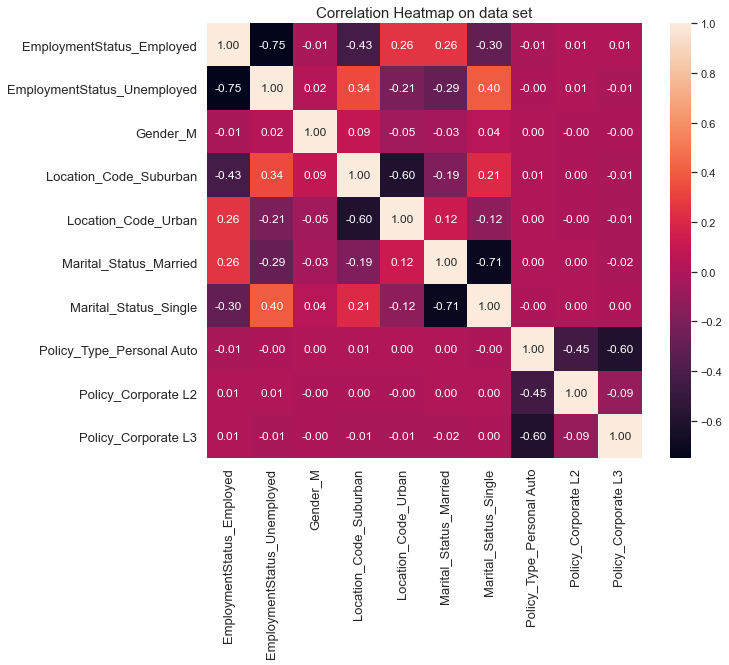

In [85]:
sns.set( rc = {'figure.figsize': (10, 8)})
plt.figure()
sns.heatmap(corr_matrix.iloc[10:20,10:20], square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=15)
plt.yticks(fontsize="13")
plt.xticks(fontsize="13")
plt.show()

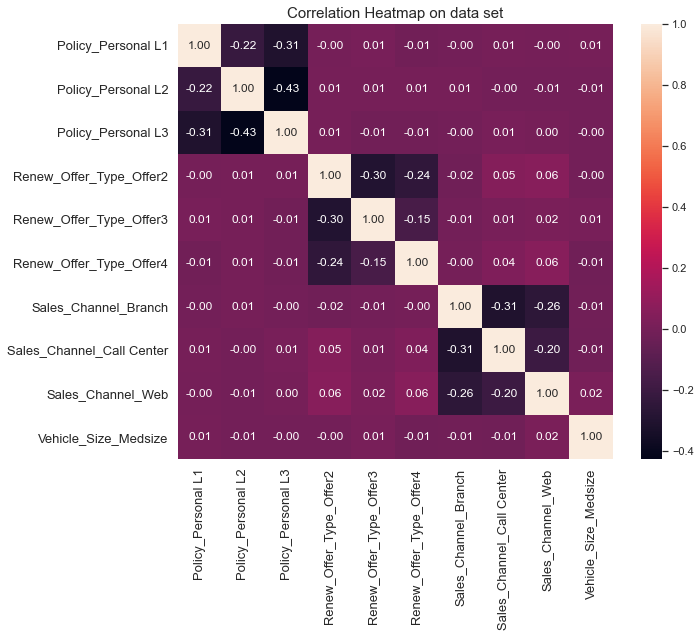

In [86]:
sns.set( rc = {'figure.figsize': (10, 8)})
plt.figure()
sns.heatmap(corr_matrix.iloc[20:30,20:30], square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=15)
plt.yticks(fontsize="13")
plt.xticks(fontsize="13")
plt.show()

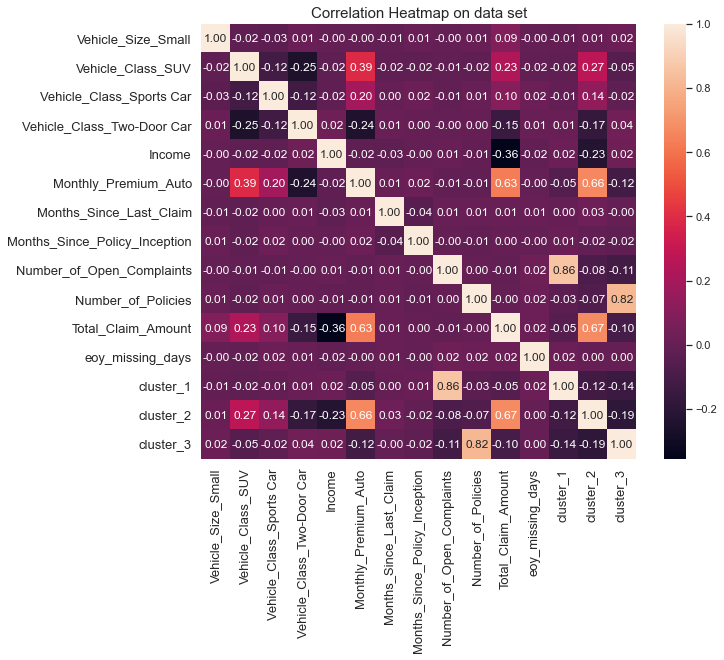

In [87]:
sns.set( rc = {'figure.figsize': (10, 8)})
plt.figure()
sns.heatmap(corr_matrix.iloc[30:,30:], square = True, annot=True, fmt='.2f')
plt.title('Correlation Heatmap on data set',size=15)
plt.yticks(fontsize="13")
plt.xticks(fontsize="13")
plt.show()

In [88]:
# Select correlated features and removed it
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.75)]
to_drop

['EmploymentStatus_Unemployed',
 'Vehicle_Size_Small',
 'Income',
 'cluster_1',
 'cluster_3']

In [89]:
# Drop features 
X_all = X_all.drop(X_all[to_drop], axis=1)

In [90]:
# Look at the new data set
X_all.shape

(9134, 40)

# Modeling & Prediction of CLV in the next 3 months

### Modeling on data set with feature engineering by K-Means

In [91]:
all = X_all.copy()
all = pd.concat([df_new[['Customer_Lifetime_Value','Effective_Date']], X_all], axis=1)

In [92]:
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all[all['Effective_Date'] <= '2011-09-30']
test = all[all['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [93]:
# Create a month list 
month = test['month'].tolist()

# Subsetting
def subtable(test,month):
    return (test[(test['month'] == month)])

# Subsetting test
test_1 = subtable(test, 10)
test_2 = subtable(test, 11)
test_3 = subtable(test, 12)

In [94]:
# Normalization of data
scaling = MinMaxScaler()

In [95]:
# 10-2011
X_train = train.copy()
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_1.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '10-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_1 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_1 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict'])
X_test = X_test.reset_index(drop=True)
pred_1 = pd.concat([predictions_te_1, X_test], axis=1)

In [96]:
# 11-2011
X_train = train.copy()
X_train = X_train.append(test_1)
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_2.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '11-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_2 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_2 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict'])
X_test = X_test.reset_index(drop=True)
pred_2 = pd.concat([predictions_te_2, X_test], axis=1)


In [97]:
# 12-2011
X_train = train.copy()
X_train = X_train.append([test_1,test_2])
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_3.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
month = '12-2011'
model = GradientBoostingRegressor(random_state=0)
kf = KFold(n_splits=5)
param_grid = {}
score = []
my_model = GridSearchCV(model,param_grid,cv=kf)
my_model.fit(X_train_sc, y_train)
predictions_tr = my_model.predict(X_train_sc) 
predictions_te = my_model.predict(X_test_sc)
CLV_predict = predictions_te
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_te))
score_dict = {
        'month': month,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    }
score.append(score_dict)
score_3 = pd.DataFrame(score, columns = ['month','rmse_train', 'rmse_test'])
predictions_te_3 = pd.DataFrame(predictions_te, columns = ['Customer_Lifetime_Value_predict'])
X_test = X_test.reset_index(drop=True)
pred_3 = pd.concat([predictions_te_3, X_test], axis=1)


# Results Analysis

In [98]:
predictions_te = pd.concat([predictions_te_1,predictions_te_2,predictions_te_3], axis=0)
score_3M = pd.concat([score_1,score_2,score_3], axis=0)
score_3M

month   rmse_train    rmse_test
0  10-2011  3584.226535  3376.872777
0  11-2011  3576.245154  3845.577104
0  12-2011  3585.853826  3760.876350

In [99]:
score_3M['rmse_train'].mean()

3582.1085053920287

In [100]:
score_3M['rmse_test'].mean()

3661.1087437741103

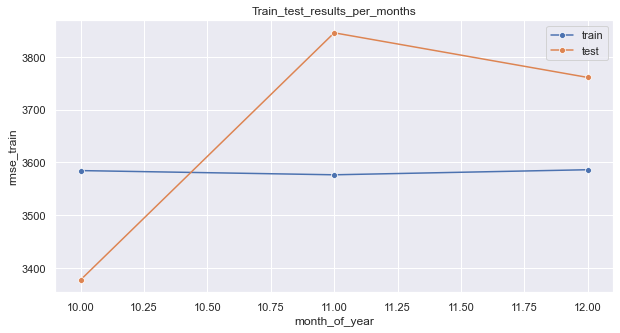

In [101]:
sns.set( rc = {'figure.figsize': (10, 5)})
plt.figure()
score_3M['month_of_year'] = pd.DatetimeIndex(score_3M['month']).month
sns.lineplot(data=score_3M, x="month_of_year", y="rmse_train", label='train', marker="o")
axes = plt.gca()
sns.lineplot(data=score_3M, x="month_of_year", y="rmse_test", label='test', marker="o")
plt.title('Train_test_results_per_months')
plt.show()

In [102]:
test_df = all[all['Effective_Date'] >= '2011-10-01']
test_df = pd.concat([test_df, predictions_te.set_index(test.index)], axis=1)


In [103]:
test_2 = df_new[df_new['Effective_Date'] >= '2011-10-01']
test_2_df = pd.concat([test_2, predictions_te.set_index(test.index)], axis=1)

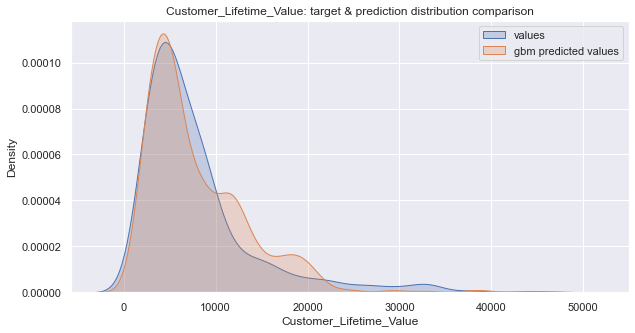

In [104]:
# Plot results
fig,ax = plt.subplots(1, 1)
sns.kdeplot(x=test_df['Customer_Lifetime_Value'], fill=True, palette="crest", label="values",)
sns.kdeplot(x=test_df['Customer_Lifetime_Value_predict'], fill=True, palette="crest", label='gbm predicted values')
plt.title('Customer_Lifetime_Value: target & prediction distribution comparison')
ax.legend()
plt.show()

### Binning

In [105]:
binsize_c = 13

In [106]:
claim_range = test_df['Total_Claim_Amount'].max() - test_df['Total_Claim_Amount'].min()
claim_range

1723.3473039999997

In [107]:
# lower and upper boundaries
min_value_c = int(np.floor(test_df['Total_Claim_Amount'].min()))
max_value_c = int(np.floor(test_df['Total_Claim_Amount'].max()))
inter_value_c = int(np.round(claim_range / binsize_c))
min_value_c, max_value_c, inter_value_c

(0, 1724, 133)

In [108]:
# interval limits to generate the bins
intervals_c = [i for i in range(min_value_c, max_value_c+inter_value_c, inter_value_c)]
intervals_c

[0, 133, 266, 399, 532, 665, 798, 931, 1064, 1197, 1330, 1463, 1596, 1729]

In [109]:
# Total_Claim_Amount discretization
test_df['Total_Claim_Amount_binned'] = pd.cut(x=test_df['Total_Claim_Amount'],
                             bins=intervals_c,
                             include_lowest=True)

In [110]:
claim_binned = test_df.groupby('Total_Claim_Amount_binned')['Total_Claim_Amount'].count()
claim_binned

Total_Claim_Amount_binned
(-0.001, 133.0]     146
(133.0, 266.0]      104
(266.0, 399.0]      261
(399.0, 532.0]      193
(532.0, 665.0]      103
(665.0, 798.0]       51
(798.0, 931.0]       40
(931.0, 1064.0]      25
(1064.0, 1197.0]     12
(1197.0, 1330.0]      8
(1330.0, 1463.0]      9
(1463.0, 1596.0]      2
(1596.0, 1729.0]      1
Name: Total_Claim_Amount, dtype: int64

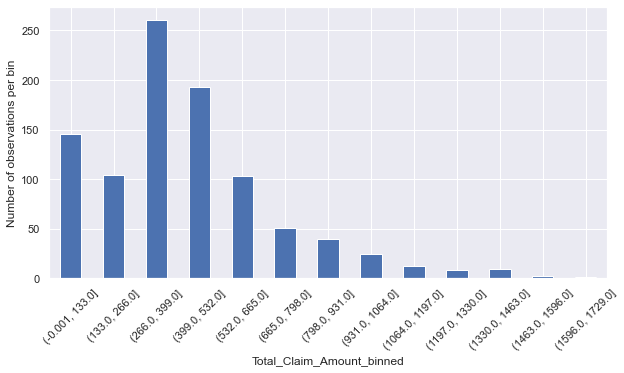

In [111]:
test_df.groupby('Total_Claim_Amount_binned')['Total_Claim_Amount'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')
plt.show()

### Results by grouping data

In [112]:
# group test on Total_Claim_Amount
test_df_group_claim = test_df.groupby(['Total_Claim_Amount_binned'])['Customer_Lifetime_Value','Customer_Lifetime_Value_predict'].sum().reset_index()

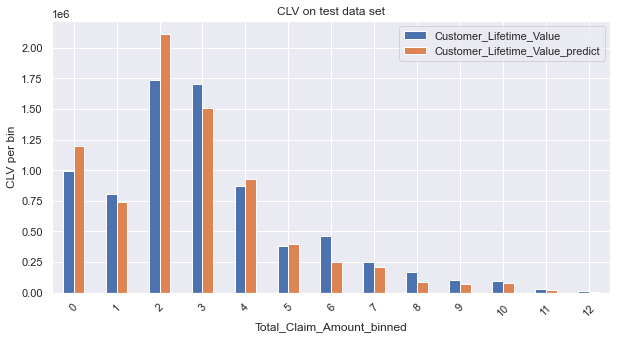

In [113]:
test_df_group_claim.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('CLV per bin')
plt.xlabel('Total_Claim_Amount_binned')
plt.title('CLV on test data set')
plt.show()

In [114]:
# group test on Monthly Premium Auto
test_df_group_premium = test_df.groupby(['Monthly_Premium_Auto'])['Customer_Lifetime_Value','Customer_Lifetime_Value_predict'].sum().reset_index()

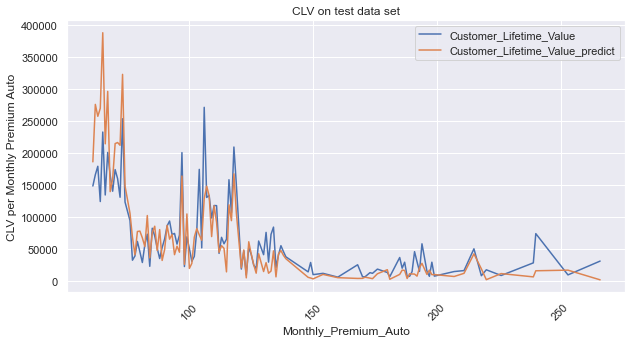

In [115]:
test_df_group_premium.plot(x='Monthly_Premium_Auto', y=['Customer_Lifetime_Value','Customer_Lifetime_Value_predict'])
plt.ylabel('CLV per Monthly Premium Auto')
plt.xlabel('Monthly_Premium_Auto')
plt.title('CLV on test data set')
plt.xticks(rotation=45)
plt.show()

In [116]:
# group test on location_code
test_2_df_group_location = test_2_df.groupby(['Location_Code'])['Customer_Lifetime_Value','Customer_Lifetime_Value_predict'].sum().reset_index()

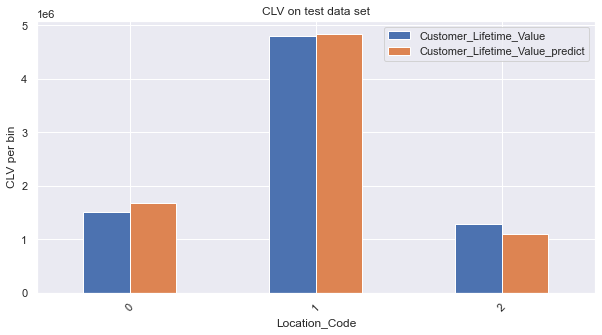

In [117]:
test_2_df_group_location.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('CLV per bin')
plt.xlabel('Location_Code')
plt.title('CLV on test data set')
plt.show()

In [118]:
# group test on Education
test_2_df_group_education = test_2_df.groupby(['Education'])['Customer_Lifetime_Value','Customer_Lifetime_Value_predict'].sum().reset_index()

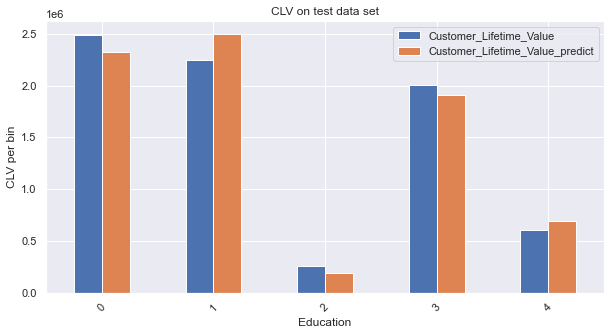

In [119]:
test_2_df_group_education.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('CLV per bin')
plt.xlabel('Education')
plt.title('CLV on test data set')
plt.show()

### Feature Importance

In [123]:
# to Refresh
# Split data set train/test set:test set is built on the last 3 months to the end of the year 
train = all[all['Effective_Date'] <= '2011-09-30']
test = all[all['Effective_Date'] >= '2011-10-01']
train['month'] = pd.DatetimeIndex(train['Effective_Date']).month
test['month'] = pd.DatetimeIndex(test['Effective_Date']).month
train = train.drop(['Effective_Date'], axis=1)
test = test.drop(['Effective_Date'], axis=1)

In [124]:
# Create a month list 
month = test['month'].tolist()

# Subsetting
def subtable(test,month):
    return (test[(test['month'] == month)])

# Subsetting test
test_1 = subtable(test, 10)
test_2 = subtable(test, 11)
test_3 = subtable(test, 12)

In [125]:
# 10_2011
X_train = train.copy()
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_1.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
gbm_model_1 = GradientBoostingRegressor(random_state=0).fit(X_train_sc,y_train)
y_hat = gbm_model_1.predict(X_test_sc)

Text(0.5, 1.0, 'GBM Features Importance month 1')

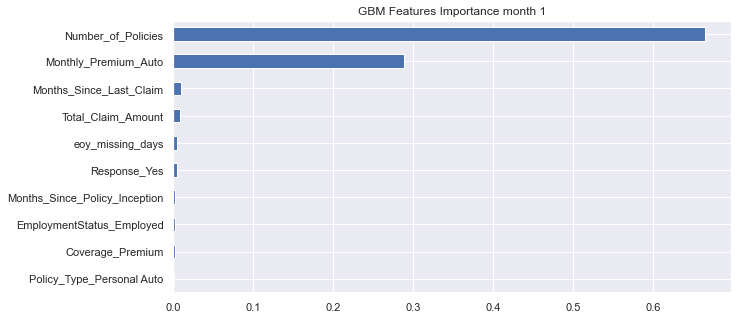

In [126]:
# Top relevant features from GBM
(pd.Series(gbm_model_1.feature_importances_, index=X_train.columns).nlargest(10).sort_values(ascending = True).plot(kind='barh')).set_title("GBM Features Importance month 1")

In [127]:
# 11_2011
X_train = train.copy()
X_train = X_train.append(test_1)
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_2.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
gbm_model_2 = GradientBoostingRegressor(random_state=0).fit(X_train_sc,y_train)
y_hat = gbm_model_2.predict(X_test_sc)

Text(0.5, 1.0, 'GBM Features Importance month 2')

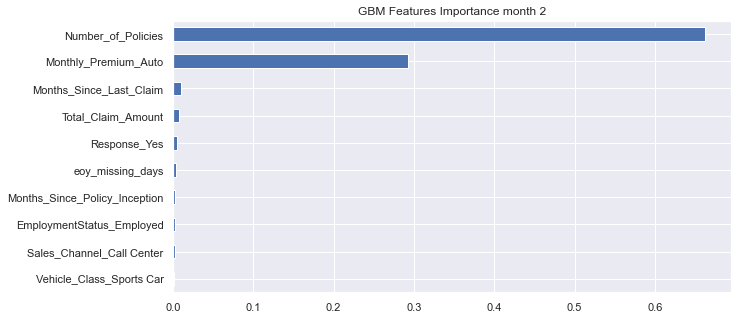

In [128]:
# Top relevant features from GBM
(pd.Series(gbm_model_2.feature_importances_, index=X_train.columns).nlargest(10).sort_values(ascending = True).plot(kind='barh')).set_title("GBM Features Importance month 2")

In [129]:
# 12-2011
X_train = train.copy()
X_train = X_train.append([test_1,test_2])
y_train = X_train.Customer_Lifetime_Value
X_train.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_train_sc = scaling.fit_transform(X_train)
X_test = test_3.copy()
y_test = X_test.Customer_Lifetime_Value
X_test.drop(['Customer_Lifetime_Value'], axis=1, inplace=True)
# Normalization of data
X_test_sc = scaling.transform(X_test)
gbm_model_3 = GradientBoostingRegressor(random_state=0).fit(X_train_sc,y_train)
y_hat = gbm_model_3.predict(X_test_sc)

Text(0.5, 1.0, 'GBM Features Importance month 3')

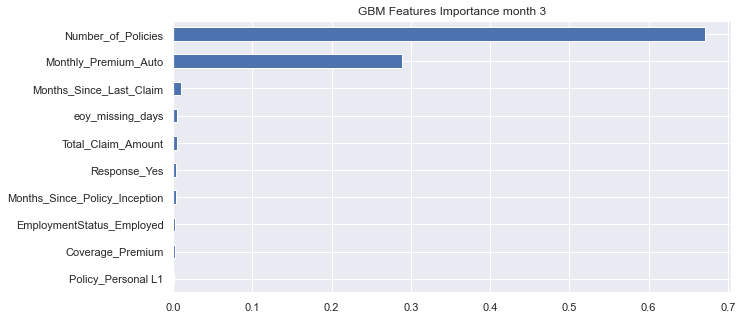

In [130]:
# Top relevant features from GBM
(pd.Series(gbm_model_3.feature_importances_, index=X_train.columns).nlargest(10).sort_values(ascending = True).plot(kind='barh')).set_title("GBM Features Importance month 3")